# Play Super Mario Bros with a Double Deep Q-Network

For a more detailed breakdown of the code, check out the full tutorial [on the Paperspace blog](https://blog.paperspace.com/building-double-deep-q-network-super-mario-bros/).

In [8]:
## Install the following if on a new instance, otherwise they'll ship with the container.
# !pip install nes-py==0.2.6
# !pip install gym-super-mario-bros
# !apt-get update
# !apt-get install ffmpeg libsm6 libxext6  -y

In [1]:
import torch
import torch.nn as nn
import random
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from tqdm import tqdm
import pickle 
from gym_super_mario_bros.actions import RIGHT_ONLY
import gym
import numpy as np
import collections 
import cv2
import matplotlib.pyplot as plt

In [2]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        """Return only every `skip`-th frame"""
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        """Clear past frame buffer and init to first obs"""
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs


class ProcessFrame84(gym.ObservationWrapper):
    """
    Downsamples image to 84x84
    Greyscales image

    Returns numpy array
    """
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return ProcessFrame84.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 240 * 256 * 3:
            img = np.reshape(frame, [240, 256, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution."
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)


class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]),
                                                dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class ScaledFloatFrame(gym.ObservationWrapper):
    """Normalize pixel values in frame --> 0 to 1"""
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0


class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer


def make_env(env):
    env = MaxAndSkipEnv(env)
    env = ProcessFrame84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    env = ScaledFloatFrame(env)
    return JoypadSpace(env, RIGHT_ONLY)

In [3]:
class DQNSolver(nn.Module):

    def __init__(self, input_shape, n_actions):
        super(DQNSolver, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)
    

class DQNAgent:

    def __init__(self, state_space, action_space, max_memory_size, batch_size, gamma, lr,
                 dropout, exploration_max, exploration_min, exploration_decay, double_dq, pretrained):

        # Define DQN Layers
        self.state_space = state_space
        self.action_space = action_space
        self.double_dq = double_dq
        self.pretrained = pretrained
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        if self.double_dq:  
            self.local_net = DQNSolver(state_space, action_space).to(self.device)
            self.target_net = DQNSolver(state_space, action_space).to(self.device)
            
            if self.pretrained:
                self.local_net.load_state_dict(torch.load("dq1.pt", map_location=torch.device(self.device)))
                self.target_net.load_state_dict(torch.load("dq2.pt", map_location=torch.device(self.device)))
                    
            self.optimizer = torch.optim.Adam(self.local_net.parameters(), lr=lr)
            self.copy = 5000  # Copy the local model weights into the target network every 5000 steps
            self.step = 0
        else:  
            self.dqn = DQNSolver(state_space, action_space).to(self.device)
            
            if self.pretrained:
                self.dqn.load_state_dict(torch.load("dq.pt", map_location=torch.device(self.device)))
            self.optimizer = torch.optim.Adam(self.dqn.parameters(), lr=lr)

        # Create memory
        self.max_memory_size = max_memory_size
        if self.pretrained:
            self.STATE_MEM = torch.load("STATE_MEM.pt")
            self.ACTION_MEM = torch.load("ACTION_MEM.pt")
            self.REWARD_MEM = torch.load("REWARD_MEM.pt")
            self.STATE2_MEM = torch.load("STATE2_MEM.pt")
            self.DONE_MEM = torch.load("DONE_MEM.pt")
            with open("ending_position.pkl", 'rb') as f:
                self.ending_position = pickle.load(f)
            with open("num_in_queue.pkl", 'rb') as f:
                self.num_in_queue = pickle.load(f)
        else:
            self.STATE_MEM = torch.zeros(max_memory_size, *self.state_space)
            self.ACTION_MEM = torch.zeros(max_memory_size, 1)
            self.REWARD_MEM = torch.zeros(max_memory_size, 1)
            self.STATE2_MEM = torch.zeros(max_memory_size, *self.state_space)
            self.DONE_MEM = torch.zeros(max_memory_size, 1)
            self.ending_position = 0
            self.num_in_queue = 0
        
        self.memory_sample_size = batch_size
        
        # Learning parameters
        self.gamma = gamma
        self.l1 = nn.SmoothL1Loss().to(self.device) # Also known as Huber loss
        self.exploration_max = exploration_max
        self.exploration_rate = exploration_max
        self.exploration_min = exploration_min
        self.exploration_decay = exploration_decay

    def remember(self, state, action, reward, state2, done):
        self.STATE_MEM[self.ending_position] = state.float()
        self.ACTION_MEM[self.ending_position] = action.float()
        self.REWARD_MEM[self.ending_position] = reward.float()
        self.STATE2_MEM[self.ending_position] = state2.float()
        self.DONE_MEM[self.ending_position] = done.float()
        self.ending_position = (self.ending_position + 1) % self.max_memory_size  # FIFO tensor
        self.num_in_queue = min(self.num_in_queue + 1, self.max_memory_size)
        
    def recall(self):
        # Randomly sample 'batch size' experiences
        idx = random.choices(range(self.num_in_queue), k=self.memory_sample_size)
        
        STATE = self.STATE_MEM[idx]
        ACTION = self.ACTION_MEM[idx]
        REWARD = self.REWARD_MEM[idx]
        STATE2 = self.STATE2_MEM[idx]
        DONE = self.DONE_MEM[idx]
        
        return STATE, ACTION, REWARD, STATE2, DONE

    def act(self, state):
        # Epsilon-greedy action
        
        if self.double_dq:
            self.step += 1
        if random.random() < self.exploration_rate:  
            return torch.tensor([[random.randrange(self.action_space)]])
        if self.double_dq:
            # Local net is used for the policy
            return torch.argmax(self.local_net(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()
        else:
            return torch.argmax(self.dqn(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()

    def copy_model(self):
        # Copy local net weights into target net
        
        self.target_net.load_state_dict(self.local_net.state_dict())
    
    def experience_replay(self):
        
        if self.double_dq and self.step % self.copy == 0:
            self.copy_model()

        if self.memory_sample_size > self.num_in_queue:
            return

        STATE, ACTION, REWARD, STATE2, DONE = self.recall()
        STATE = STATE.to(self.device)
        ACTION = ACTION.to(self.device)
        REWARD = REWARD.to(self.device)
        STATE2 = STATE2.to(self.device)
        DONE = DONE.to(self.device)
        
        self.optimizer.zero_grad()
        if self.double_dq:
            # Double Q-Learning target is Q*(S, A) <- r + γ max_a Q_target(S', a)
            target = REWARD + torch.mul((self.gamma * 
                                        self.target_net(STATE2).max(1).values.unsqueeze(1)), 
                                        1 - DONE)

            current = self.local_net(STATE).gather(1, ACTION.long()) # Local net approximation of Q-value
        else:
            # Q-Learning target is Q*(S, A) <- r + γ max_a Q(S', a) 
            target = REWARD + torch.mul((self.gamma * 
                                        self.dqn(STATE2).max(1).values.unsqueeze(1)), 
                                        1 - DONE)
                
            current = self.dqn(STATE).gather(1, ACTION.long())
        
        loss = self.l1(current, target)
        loss.backward() # Compute gradients
        self.optimizer.step() # Backpropagate error

        self.exploration_rate *= self.exploration_decay
        
        # Makes sure that exploration rate is always at least 'exploration min'
        self.exploration_rate = max(self.exploration_rate, self.exploration_min)

In [4]:
def vectorize_action(action, action_space):
    # Given a scalar action, return a one-hot encoded action
    
    return [0 for _ in range(action)] + [1] + [0 for _ in range(action + 1, action_space)]

In [5]:
def show_state(env, ep=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Episode: %d %s" % (ep, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

  0%|          | 1/1000 [00:07<2:12:26,  7.95s/it]

Total reward after episode 1 is 1407.0


  0%|          | 2/1000 [00:08<1:36:59,  5.83s/it]

Total reward after episode 2 is 250.0


  0%|          | 3/1000 [00:13<1:31:44,  5.52s/it]

Total reward after episode 3 is 633.0


  0%|          | 4/1000 [00:14<1:08:32,  4.13s/it]

Total reward after episode 4 is 251.0


  0%|          | 5/1000 [00:17<1:02:16,  3.76s/it]

Total reward after episode 5 is 611.0


  1%|          | 6/1000 [00:18<47:59,  2.90s/it]  

Total reward after episode 6 is 251.0


  1%|          | 7/1000 [00:19<37:38,  2.27s/it]

Total reward after episode 7 is 251.0


  1%|          | 8/1000 [00:19<30:15,  1.83s/it]

Total reward after episode 8 is 248.0


  1%|          | 9/1000 [00:20<24:57,  1.51s/it]

Total reward after episode 9 is 248.0


  1%|          | 10/1000 [00:24<36:31,  2.21s/it]

Total reward after episode 10 is 639.0


  1%|          | 11/1000 [00:25<29:51,  1.81s/it]

Total reward after episode 11 is 250.0


  1%|          | 12/1000 [00:26<25:02,  1.52s/it]

Total reward after episode 12 is 248.0


  1%|▏         | 13/1000 [00:27<21:42,  1.32s/it]

Total reward after episode 13 is 250.0


  1%|▏         | 14/1000 [00:27<18:51,  1.15s/it]

Total reward after episode 14 is 248.0


  2%|▏         | 15/1000 [00:28<16:55,  1.03s/it]

Total reward after episode 15 is 247.0


  2%|▏         | 16/1000 [00:29<16:02,  1.02it/s]

Total reward after episode 16 is 250.0


  2%|▏         | 17/1000 [00:30<15:08,  1.08it/s]

Total reward after episode 17 is 251.0


  2%|▏         | 18/1000 [00:32<22:01,  1.35s/it]

Total reward after episode 18 is 617.0


  2%|▏         | 19/1000 [00:33<19:27,  1.19s/it]

Total reward after episode 19 is 251.0


  2%|▏         | 20/1000 [00:36<30:24,  1.86s/it]

Total reward after episode 20 is 606.0


  2%|▏         | 21/1000 [00:37<25:06,  1.54s/it]

Total reward after episode 21 is 248.0


  2%|▏         | 22/1000 [00:38<21:43,  1.33s/it]

Total reward after episode 22 is 248.0


  2%|▏         | 23/1000 [00:44<43:08,  2.65s/it]

Total reward after episode 23 is 625.0


  2%|▏         | 24/1000 [00:44<34:03,  2.09s/it]

Total reward after episode 24 is 248.0


  2%|▎         | 25/1000 [00:45<27:39,  1.70s/it]

Total reward after episode 25 is 249.0


  3%|▎         | 26/1000 [00:46<22:57,  1.41s/it]

Total reward after episode 26 is 248.0


  3%|▎         | 27/1000 [00:47<19:49,  1.22s/it]

Total reward after episode 27 is 249.0


  3%|▎         | 28/1000 [00:48<17:50,  1.10s/it]

Total reward after episode 28 is 250.0


  3%|▎         | 29/1000 [00:48<16:29,  1.02s/it]

Total reward after episode 29 is 250.0


  3%|▎         | 30/1000 [00:54<39:55,  2.47s/it]

Total reward after episode 30 is 751.0


  3%|▎         | 31/1000 [00:55<31:23,  1.94s/it]

Total reward after episode 31 is 247.0


  3%|▎         | 32/1000 [00:56<25:44,  1.60s/it]

Total reward after episode 32 is 248.0


  3%|▎         | 33/1000 [00:57<22:03,  1.37s/it]

Total reward after episode 33 is 252.0


  3%|▎         | 34/1000 [01:04<50:19,  3.13s/it]

Total reward after episode 34 is 615.0


  4%|▎         | 35/1000 [01:09<59:19,  3.69s/it]

Total reward after episode 35 is 630.0


  4%|▎         | 36/1000 [01:10<45:07,  2.81s/it]

Total reward after episode 36 is 247.0


  4%|▎         | 37/1000 [01:10<35:11,  2.19s/it]

Total reward after episode 37 is 248.0


  4%|▍         | 38/1000 [01:11<28:09,  1.76s/it]

Total reward after episode 38 is 248.0


  4%|▍         | 39/1000 [01:12<23:30,  1.47s/it]

Total reward after episode 39 is 250.0


  4%|▍         | 40/1000 [01:13<20:42,  1.29s/it]

Total reward after episode 40 is 250.0


  4%|▍         | 41/1000 [01:14<18:28,  1.16s/it]

Total reward after episode 41 is 250.0


  4%|▍         | 42/1000 [01:14<16:54,  1.06s/it]

Total reward after episode 42 is 250.0


  4%|▍         | 43/1000 [01:15<15:42,  1.02it/s]

Total reward after episode 43 is 249.0


  4%|▍         | 44/1000 [01:16<15:12,  1.05it/s]

Total reward after episode 44 is 248.0


  4%|▍         | 45/1000 [01:17<14:39,  1.09it/s]

Total reward after episode 45 is 250.0


  5%|▍         | 46/1000 [01:20<23:53,  1.50s/it]

Total reward after episode 46 is 609.0


  5%|▍         | 47/1000 [01:21<20:30,  1.29s/it]

Total reward after episode 47 is 250.0


  5%|▍         | 48/1000 [01:22<18:33,  1.17s/it]

Total reward after episode 48 is 250.0


  5%|▍         | 49/1000 [01:22<17:13,  1.09s/it]

Total reward after episode 49 is 250.0


  5%|▌         | 50/1000 [01:23<16:07,  1.02s/it]

Total reward after episode 50 is 248.0


  5%|▌         | 51/1000 [01:24<15:04,  1.05it/s]

Total reward after episode 51 is 248.0


  5%|▌         | 52/1000 [01:25<13:58,  1.13it/s]

Total reward after episode 52 is 248.0


  5%|▌         | 53/1000 [01:26<13:21,  1.18it/s]

Total reward after episode 53 is 247.0


  5%|▌         | 54/1000 [01:29<25:38,  1.63s/it]

Total reward after episode 54 is 629.0


  6%|▌         | 55/1000 [01:30<21:58,  1.39s/it]

Total reward after episode 55 is 251.0


  6%|▌         | 56/1000 [01:34<36:48,  2.34s/it]

Total reward after episode 56 is 811.0


  6%|▌         | 57/1000 [01:35<29:27,  1.87s/it]

Total reward after episode 57 is 247.0


  6%|▌         | 58/1000 [01:36<24:53,  1.59s/it]

Total reward after episode 58 is 247.0


  6%|▌         | 59/1000 [01:37<20:51,  1.33s/it]

Total reward after episode 59 is 248.0


  6%|▌         | 60/1000 [01:43<42:13,  2.69s/it]

Total reward after episode 60 is 1031.0


  6%|▌         | 61/1000 [01:43<33:02,  2.11s/it]

Total reward after episode 61 is 250.0


  6%|▌         | 62/1000 [01:44<27:36,  1.77s/it]

Total reward after episode 62 is 248.0


  6%|▋         | 63/1000 [01:45<23:34,  1.51s/it]

Total reward after episode 63 is 252.0


  6%|▋         | 64/1000 [01:46<19:49,  1.27s/it]

Total reward after episode 64 is 252.0


  6%|▋         | 65/1000 [01:47<17:45,  1.14s/it]

Total reward after episode 65 is 251.0


  7%|▋         | 66/1000 [01:48<16:04,  1.03s/it]

Total reward after episode 66 is 251.0


  7%|▋         | 67/1000 [01:48<14:37,  1.06it/s]

Total reward after episode 67 is 252.0


  7%|▋         | 68/1000 [01:49<13:30,  1.15it/s]

Total reward after episode 68 is 251.0


  7%|▋         | 69/1000 [01:50<13:08,  1.18it/s]

Total reward after episode 69 is 250.0


  7%|▋         | 70/1000 [01:51<13:39,  1.13it/s]

Total reward after episode 70 is 252.0


  7%|▋         | 71/1000 [01:52<13:31,  1.15it/s]

Total reward after episode 71 is 248.0


  7%|▋         | 72/1000 [01:53<13:13,  1.17it/s]

Total reward after episode 72 is 250.0


  7%|▋         | 73/1000 [01:53<13:00,  1.19it/s]

Total reward after episode 73 is 251.0


  7%|▋         | 74/1000 [01:54<12:49,  1.20it/s]

Total reward after episode 74 is 249.0


  8%|▊         | 75/1000 [01:55<12:38,  1.22it/s]

Total reward after episode 75 is 248.0


  8%|▊         | 76/1000 [01:56<12:25,  1.24it/s]

Total reward after episode 76 is 248.0


  8%|▊         | 77/1000 [01:57<12:15,  1.25it/s]

Total reward after episode 77 is 250.0


  8%|▊         | 78/1000 [01:57<12:20,  1.25it/s]

Total reward after episode 78 is 252.0


  8%|▊         | 79/1000 [01:58<12:03,  1.27it/s]

Total reward after episode 79 is 252.0


  8%|▊         | 80/1000 [01:59<12:01,  1.28it/s]

Total reward after episode 80 is 248.0


  8%|▊         | 81/1000 [02:01<18:41,  1.22s/it]

Total reward after episode 81 is 638.0


  8%|▊         | 82/1000 [02:02<16:31,  1.08s/it]

Total reward after episode 82 is 248.0


  8%|▊         | 83/1000 [02:03<15:08,  1.01it/s]

Total reward after episode 83 is 248.0


  8%|▊         | 84/1000 [02:03<14:18,  1.07it/s]

Total reward after episode 84 is 250.0


  8%|▊         | 85/1000 [02:04<13:20,  1.14it/s]

Total reward after episode 85 is 247.0


  9%|▊         | 86/1000 [02:05<12:59,  1.17it/s]

Total reward after episode 86 is 248.0


  9%|▊         | 87/1000 [02:06<12:43,  1.20it/s]

Total reward after episode 87 is 252.0


  9%|▉         | 88/1000 [02:07<12:30,  1.22it/s]

Total reward after episode 88 is 247.0


  9%|▉         | 89/1000 [02:07<12:53,  1.18it/s]

Total reward after episode 89 is 250.0


  9%|▉         | 90/1000 [02:08<12:24,  1.22it/s]

Total reward after episode 90 is 252.0


  9%|▉         | 91/1000 [02:09<12:07,  1.25it/s]

Total reward after episode 91 is 247.0


  9%|▉         | 92/1000 [02:10<12:01,  1.26it/s]

Total reward after episode 92 is 251.0


  9%|▉         | 93/1000 [02:11<11:53,  1.27it/s]

Total reward after episode 93 is 252.0


  9%|▉         | 94/1000 [02:11<11:54,  1.27it/s]

Total reward after episode 94 is 251.0


 10%|▉         | 95/1000 [02:14<18:42,  1.24s/it]

Total reward after episode 95 is 635.0


 10%|▉         | 96/1000 [02:14<16:39,  1.11s/it]

Total reward after episode 96 is 248.0


 10%|▉         | 97/1000 [02:15<15:40,  1.04s/it]

Total reward after episode 97 is 248.0


 10%|▉         | 98/1000 [02:16<15:17,  1.02s/it]

Total reward after episode 98 is 237.0


 10%|▉         | 99/1000 [02:17<14:43,  1.02it/s]

Total reward after episode 99 is 249.0


 10%|█         | 100/1000 [02:18<13:59,  1.07it/s]

Total reward after episode 100 is 248.0


 10%|█         | 101/1000 [02:19<13:07,  1.14it/s]

Total reward after episode 101 is 251.0


 10%|█         | 102/1000 [02:19<12:36,  1.19it/s]

Total reward after episode 102 is 250.0


 10%|█         | 103/1000 [02:20<12:34,  1.19it/s]

Total reward after episode 103 is 248.0


 10%|█         | 104/1000 [02:21<12:50,  1.16it/s]

Total reward after episode 104 is 240.0


 10%|█         | 105/1000 [02:22<12:18,  1.21it/s]

Total reward after episode 105 is 251.0


 11%|█         | 106/1000 [02:23<12:38,  1.18it/s]

Total reward after episode 106 is 247.0


 11%|█         | 107/1000 [02:24<12:40,  1.17it/s]

Total reward after episode 107 is 250.0


 11%|█         | 108/1000 [02:25<12:25,  1.20it/s]

Total reward after episode 108 is 249.0


 11%|█         | 109/1000 [02:25<12:03,  1.23it/s]

Total reward after episode 109 is 252.0


 11%|█         | 110/1000 [02:26<11:45,  1.26it/s]

Total reward after episode 110 is 252.0


 11%|█         | 111/1000 [02:28<17:07,  1.16s/it]

Total reward after episode 111 is 625.0


 11%|█         | 112/1000 [02:37<51:13,  3.46s/it]

Total reward after episode 112 is 1012.0


 11%|█▏        | 113/1000 [02:40<51:36,  3.49s/it]

Total reward after episode 113 is 735.0


 11%|█▏        | 114/1000 [02:41<39:18,  2.66s/it]

Total reward after episode 114 is 252.0


 12%|█▏        | 115/1000 [02:42<30:58,  2.10s/it]

Total reward after episode 115 is 251.0


 12%|█▏        | 116/1000 [02:43<24:47,  1.68s/it]

Total reward after episode 116 is 252.0


 12%|█▏        | 117/1000 [02:44<21:13,  1.44s/it]

Total reward after episode 117 is 252.0


 12%|█▏        | 118/1000 [02:44<18:25,  1.25s/it]

Total reward after episode 118 is 252.0


 12%|█▏        | 119/1000 [02:47<22:27,  1.53s/it]

Total reward after episode 119 is 632.0


 12%|█▏        | 120/1000 [02:47<18:55,  1.29s/it]

Total reward after episode 120 is 252.0


 12%|█▏        | 121/1000 [02:48<16:38,  1.14s/it]

Total reward after episode 121 is 251.0


 12%|█▏        | 122/1000 [02:49<14:52,  1.02s/it]

Total reward after episode 122 is 252.0


 12%|█▏        | 123/1000 [02:51<18:12,  1.25s/it]

Total reward after episode 123 is 625.0


 12%|█▏        | 124/1000 [02:51<16:04,  1.10s/it]

Total reward after episode 124 is 252.0


 12%|█▎        | 125/1000 [02:55<26:06,  1.79s/it]

Total reward after episode 125 is 628.0


 13%|█▎        | 126/1000 [02:55<21:26,  1.47s/it]

Total reward after episode 126 is 252.0


 13%|█▎        | 127/1000 [02:56<18:02,  1.24s/it]

Total reward after episode 127 is 252.0


 13%|█▎        | 128/1000 [02:57<15:36,  1.07s/it]

Total reward after episode 128 is 252.0


 13%|█▎        | 129/1000 [02:58<13:59,  1.04it/s]

Total reward after episode 129 is 252.0


 13%|█▎        | 130/1000 [02:58<12:57,  1.12it/s]

Total reward after episode 130 is 252.0


 13%|█▎        | 131/1000 [02:59<12:05,  1.20it/s]

Total reward after episode 131 is 252.0


 13%|█▎        | 132/1000 [03:01<17:17,  1.20s/it]

Total reward after episode 132 is 624.0


 13%|█▎        | 133/1000 [03:04<24:26,  1.69s/it]

Total reward after episode 133 is 631.0


 13%|█▎        | 134/1000 [03:06<25:19,  1.75s/it]

Total reward after episode 134 is 621.0


 14%|█▎        | 135/1000 [03:07<21:00,  1.46s/it]

Total reward after episode 135 is 252.0


 14%|█▎        | 136/1000 [03:07<18:00,  1.25s/it]

Total reward after episode 136 is 250.0


 14%|█▎        | 137/1000 [03:09<19:56,  1.39s/it]

Total reward after episode 137 is 625.0


 14%|█▍        | 138/1000 [03:11<23:16,  1.62s/it]

Total reward after episode 138 is 633.0


 14%|█▍        | 139/1000 [03:12<19:39,  1.37s/it]

Total reward after episode 139 is 249.0


 14%|█▍        | 140/1000 [03:13<17:05,  1.19s/it]

Total reward after episode 140 is 251.0


 14%|█▍        | 141/1000 [03:13<15:19,  1.07s/it]

Total reward after episode 141 is 251.0


 14%|█▍        | 142/1000 [03:14<14:23,  1.01s/it]

Total reward after episode 142 is 251.0


 14%|█▍        | 143/1000 [03:15<13:26,  1.06it/s]

Total reward after episode 143 is 251.0


 14%|█▍        | 144/1000 [03:17<17:08,  1.20s/it]

Total reward after episode 144 is 627.0


 14%|█▍        | 145/1000 [03:18<15:17,  1.07s/it]

Total reward after episode 145 is 247.0


 15%|█▍        | 146/1000 [03:20<19:46,  1.39s/it]

Total reward after episode 146 is 635.0


 15%|█▍        | 147/1000 [03:21<16:57,  1.19s/it]

Total reward after episode 147 is 251.0


 15%|█▍        | 148/1000 [03:21<15:06,  1.06s/it]

Total reward after episode 148 is 251.0


 15%|█▍        | 149/1000 [03:23<18:19,  1.29s/it]

Total reward after episode 149 is 627.0


 15%|█▌        | 150/1000 [03:24<16:23,  1.16s/it]

Total reward after episode 150 is 252.0


 15%|█▌        | 151/1000 [03:25<15:02,  1.06s/it]

Total reward after episode 151 is 249.0


 15%|█▌        | 152/1000 [03:26<13:52,  1.02it/s]

Total reward after episode 152 is 249.0


 15%|█▌        | 153/1000 [03:26<12:49,  1.10it/s]

Total reward after episode 153 is 251.0


 15%|█▌        | 154/1000 [03:27<11:58,  1.18it/s]

Total reward after episode 154 is 248.0


 16%|█▌        | 155/1000 [03:31<22:47,  1.62s/it]

Total reward after episode 155 is 1048.0


 16%|█▌        | 156/1000 [03:32<24:12,  1.72s/it]

Total reward after episode 156 is 636.0


 16%|█▌        | 157/1000 [03:33<19:58,  1.42s/it]

Total reward after episode 157 is 246.0


 16%|█▌        | 158/1000 [03:34<17:26,  1.24s/it]

Total reward after episode 158 is 239.0


 16%|█▌        | 159/1000 [03:35<15:12,  1.08s/it]

Total reward after episode 159 is 249.0


 16%|█▌        | 160/1000 [03:36<14:03,  1.00s/it]

Total reward after episode 160 is 248.0


 16%|█▌        | 161/1000 [03:36<13:14,  1.06it/s]

Total reward after episode 161 is 239.0


 16%|█▌        | 162/1000 [03:37<12:25,  1.12it/s]

Total reward after episode 162 is 252.0


 16%|█▋        | 163/1000 [03:39<15:56,  1.14s/it]

Total reward after episode 163 is 627.0


 16%|█▋        | 164/1000 [03:41<20:44,  1.49s/it]

Total reward after episode 164 is 636.0


 16%|█▋        | 165/1000 [03:42<18:09,  1.30s/it]

Total reward after episode 165 is 239.0


 17%|█▋        | 166/1000 [03:49<39:46,  2.86s/it]

Total reward after episode 166 is 1026.0


 17%|█▋        | 167/1000 [03:49<30:53,  2.23s/it]

Total reward after episode 167 is 248.0


 17%|█▋        | 168/1000 [03:56<49:16,  3.55s/it]

Total reward after episode 168 is 1333.0


 17%|█▋        | 169/1000 [03:57<37:30,  2.71s/it]

Total reward after episode 169 is 251.0


 17%|█▋        | 170/1000 [03:57<29:26,  2.13s/it]

Total reward after episode 170 is 249.0


 17%|█▋        | 171/1000 [03:58<24:12,  1.75s/it]

Total reward after episode 171 is 248.0


 17%|█▋        | 172/1000 [03:59<20:08,  1.46s/it]

Total reward after episode 172 is 251.0


 17%|█▋        | 173/1000 [04:00<17:07,  1.24s/it]

Total reward after episode 173 is 249.0


 17%|█▋        | 174/1000 [04:01<15:27,  1.12s/it]

Total reward after episode 174 is 239.0


 18%|█▊        | 175/1000 [04:02<14:23,  1.05s/it]

Total reward after episode 175 is 239.0


 18%|█▊        | 176/1000 [04:06<27:54,  2.03s/it]

Total reward after episode 176 is 576.0


 18%|█▊        | 177/1000 [04:07<22:53,  1.67s/it]

Total reward after episode 177 is 251.0


 18%|█▊        | 178/1000 [04:07<19:14,  1.40s/it]

Total reward after episode 178 is 249.0


 18%|█▊        | 179/1000 [04:08<16:33,  1.21s/it]

Total reward after episode 179 is 249.0


 18%|█▊        | 180/1000 [04:09<14:58,  1.10s/it]

Total reward after episode 180 is 239.0


 18%|█▊        | 181/1000 [04:10<13:52,  1.02s/it]

Total reward after episode 181 is 248.0


 18%|█▊        | 182/1000 [04:16<35:14,  2.58s/it]

Total reward after episode 182 is 1029.0


 18%|█▊        | 183/1000 [04:18<32:01,  2.35s/it]

Total reward after episode 183 is 629.0


 18%|█▊        | 184/1000 [04:19<25:57,  1.91s/it]

Total reward after episode 184 is 239.0


 18%|█▊        | 185/1000 [04:20<21:37,  1.59s/it]

Total reward after episode 185 is 244.0


 19%|█▊        | 186/1000 [04:20<18:13,  1.34s/it]

Total reward after episode 186 is 251.0


 19%|█▊        | 187/1000 [04:21<16:01,  1.18s/it]

Total reward after episode 187 is 252.0


 19%|█▉        | 188/1000 [04:22<14:21,  1.06s/it]

Total reward after episode 188 is 252.0


 19%|█▉        | 189/1000 [04:23<13:19,  1.01it/s]

Total reward after episode 189 is 251.0


 19%|█▉        | 190/1000 [04:24<12:43,  1.06it/s]

Total reward after episode 190 is 249.0


 19%|█▉        | 191/1000 [04:28<27:11,  2.02s/it]

Total reward after episode 191 is 733.0


 19%|█▉        | 192/1000 [04:29<22:11,  1.65s/it]

Total reward after episode 192 is 248.0


 19%|█▉        | 193/1000 [04:30<18:57,  1.41s/it]

Total reward after episode 193 is 246.0


 19%|█▉        | 194/1000 [04:31<16:13,  1.21s/it]

Total reward after episode 194 is 251.0


 20%|█▉        | 195/1000 [04:34<25:44,  1.92s/it]

Total reward after episode 195 is 774.0


 20%|█▉        | 196/1000 [04:35<21:08,  1.58s/it]

Total reward after episode 196 is 246.0


 20%|█▉        | 197/1000 [04:43<46:06,  3.45s/it]

Total reward after episode 197 is 1016.0


 20%|█▉        | 198/1000 [04:43<35:11,  2.63s/it]

Total reward after episode 198 is 250.0


 20%|█▉        | 199/1000 [04:47<40:20,  3.02s/it]

Total reward after episode 199 is 1041.0


 20%|██        | 200/1000 [04:48<31:13,  2.34s/it]

Total reward after episode 200 is 251.0


 20%|██        | 201/1000 [04:49<24:40,  1.85s/it]

Total reward after episode 201 is 248.0


 20%|██        | 202/1000 [04:59<57:55,  4.36s/it]

Total reward after episode 202 is 1000.0


 20%|██        | 203/1000 [05:00<43:28,  3.27s/it]

Total reward after episode 203 is 250.0


 20%|██        | 204/1000 [05:01<33:46,  2.55s/it]

Total reward after episode 204 is 250.0


 20%|██        | 205/1000 [05:01<26:29,  2.00s/it]

Total reward after episode 205 is 248.0


 21%|██        | 206/1000 [05:03<24:25,  1.85s/it]

Total reward after episode 206 is 611.0


 21%|██        | 207/1000 [05:07<34:30,  2.61s/it]

Total reward after episode 207 is 1040.0


 21%|██        | 208/1000 [05:08<27:55,  2.12s/it]

Total reward after episode 208 is 243.0


 21%|██        | 209/1000 [05:09<22:37,  1.72s/it]

Total reward after episode 209 is 251.0


 21%|██        | 210/1000 [05:10<18:56,  1.44s/it]

Total reward after episode 210 is 248.0


 21%|██        | 211/1000 [05:15<34:15,  2.60s/it]

Total reward after episode 211 is 1035.0


 21%|██        | 212/1000 [05:16<26:58,  2.05s/it]

Total reward after episode 212 is 251.0


 21%|██▏       | 213/1000 [05:17<21:59,  1.68s/it]

Total reward after episode 213 is 248.0


 21%|██▏       | 214/1000 [05:17<18:07,  1.38s/it]

Total reward after episode 214 is 248.0


 22%|██▏       | 215/1000 [05:18<15:52,  1.21s/it]

Total reward after episode 215 is 250.0


 22%|██▏       | 216/1000 [05:19<13:50,  1.06s/it]

Total reward after episode 216 is 251.0


 22%|██▏       | 217/1000 [05:21<17:00,  1.30s/it]

Total reward after episode 217 is 617.0


 22%|██▏       | 218/1000 [05:24<22:51,  1.75s/it]

Total reward after episode 218 is 616.0


 22%|██▏       | 219/1000 [05:24<19:10,  1.47s/it]

Total reward after episode 219 is 250.0


 22%|██▏       | 220/1000 [05:25<16:28,  1.27s/it]

Total reward after episode 220 is 248.0


 22%|██▏       | 221/1000 [05:26<15:04,  1.16s/it]

Total reward after episode 221 is 238.0


 22%|██▏       | 222/1000 [05:32<32:33,  2.51s/it]

Total reward after episode 222 is 1032.0


 22%|██▏       | 223/1000 [05:33<26:07,  2.02s/it]

Total reward after episode 223 is 248.0


 22%|██▏       | 224/1000 [05:37<37:07,  2.87s/it]

Total reward after episode 224 is 1039.0


 22%|██▎       | 225/1000 [05:38<28:45,  2.23s/it]

Total reward after episode 225 is 251.0


 23%|██▎       | 226/1000 [05:40<27:14,  2.11s/it]

Total reward after episode 226 is 618.0


 23%|██▎       | 227/1000 [05:41<21:42,  1.68s/it]

Total reward after episode 227 is 248.0


 23%|██▎       | 228/1000 [05:42<18:07,  1.41s/it]

Total reward after episode 228 is 250.0


 23%|██▎       | 229/1000 [05:48<38:39,  3.01s/it]

Total reward after episode 229 is 1326.0


 23%|██▎       | 230/1000 [05:49<29:54,  2.33s/it]

Total reward after episode 230 is 251.0


 23%|██▎       | 231/1000 [05:50<24:01,  1.88s/it]

Total reward after episode 231 is 249.0


 23%|██▎       | 232/1000 [05:51<19:45,  1.54s/it]

Total reward after episode 232 is 248.0


 23%|██▎       | 233/1000 [05:51<16:35,  1.30s/it]

Total reward after episode 233 is 248.0


 23%|██▎       | 234/1000 [05:52<15:26,  1.21s/it]

Total reward after episode 234 is 239.0


 24%|██▎       | 235/1000 [05:53<13:46,  1.08s/it]

Total reward after episode 235 is 252.0


 24%|██▎       | 236/1000 [05:54<12:33,  1.01it/s]

Total reward after episode 236 is 252.0


 24%|██▎       | 237/1000 [05:55<11:40,  1.09it/s]

Total reward after episode 237 is 250.0


 24%|██▍       | 238/1000 [05:56<11:50,  1.07it/s]

Total reward after episode 238 is 248.0


 24%|██▍       | 239/1000 [05:56<11:05,  1.14it/s]

Total reward after episode 239 is 250.0


 24%|██▍       | 240/1000 [06:00<22:43,  1.79s/it]

Total reward after episode 240 is 638.0


 24%|██▍       | 241/1000 [06:01<18:48,  1.49s/it]

Total reward after episode 241 is 248.0


 24%|██▍       | 242/1000 [06:04<26:16,  2.08s/it]

Total reward after episode 242 is 753.0


 24%|██▍       | 243/1000 [06:05<21:16,  1.69s/it]

Total reward after episode 243 is 248.0


 24%|██▍       | 244/1000 [06:06<17:36,  1.40s/it]

Total reward after episode 244 is 248.0


 24%|██▍       | 245/1000 [06:07<15:04,  1.20s/it]

Total reward after episode 245 is 248.0


 25%|██▍       | 246/1000 [06:09<18:51,  1.50s/it]

Total reward after episode 246 is 637.0


 25%|██▍       | 247/1000 [06:14<32:04,  2.56s/it]

Total reward after episode 247 is 1032.0


 25%|██▍       | 248/1000 [06:20<43:55,  3.50s/it]

Total reward after episode 248 is 626.0


 25%|██▍       | 249/1000 [06:24<47:28,  3.79s/it]

Total reward after episode 249 is 1043.0


 25%|██▌       | 250/1000 [06:25<36:08,  2.89s/it]

Total reward after episode 250 is 251.0


 25%|██▌       | 251/1000 [06:26<28:48,  2.31s/it]

Total reward after episode 251 is 238.0


 25%|██▌       | 252/1000 [06:27<22:43,  1.82s/it]

Total reward after episode 252 is 248.0


 25%|██▌       | 253/1000 [06:29<23:29,  1.89s/it]

Total reward after episode 253 is 625.0


 25%|██▌       | 254/1000 [06:32<30:30,  2.45s/it]

Total reward after episode 254 is 1047.0


 26%|██▌       | 255/1000 [06:33<24:03,  1.94s/it]

Total reward after episode 255 is 251.0


 26%|██▌       | 256/1000 [06:34<19:45,  1.59s/it]

Total reward after episode 256 is 248.0


 26%|██▌       | 257/1000 [06:37<23:46,  1.92s/it]

Total reward after episode 257 is 601.0


 26%|██▌       | 258/1000 [06:37<19:18,  1.56s/it]

Total reward after episode 258 is 252.0


 26%|██▌       | 259/1000 [06:38<16:23,  1.33s/it]

Total reward after episode 259 is 252.0


 26%|██▌       | 260/1000 [06:39<14:04,  1.14s/it]

Total reward after episode 260 is 252.0


 26%|██▌       | 261/1000 [06:42<21:46,  1.77s/it]

Total reward after episode 261 is 601.0


 26%|██▌       | 262/1000 [06:44<22:26,  1.82s/it]

Total reward after episode 262 is 633.0


 26%|██▋       | 263/1000 [06:46<22:55,  1.87s/it]

Total reward after episode 263 is 634.0


 26%|██▋       | 264/1000 [06:47<18:53,  1.54s/it]

Total reward after episode 264 is 248.0


 26%|██▋       | 265/1000 [06:48<16:28,  1.34s/it]

Total reward after episode 265 is 250.0


 27%|██▋       | 266/1000 [06:48<14:16,  1.17s/it]

Total reward after episode 266 is 252.0


 27%|██▋       | 267/1000 [06:49<12:27,  1.02s/it]

Total reward after episode 267 is 248.0


 27%|██▋       | 268/1000 [06:50<12:02,  1.01it/s]

Total reward after episode 268 is 235.0


 27%|██▋       | 269/1000 [06:51<11:18,  1.08it/s]

Total reward after episode 269 is 253.0


 27%|██▋       | 270/1000 [06:51<10:35,  1.15it/s]

Total reward after episode 270 is 248.0


 27%|██▋       | 271/1000 [06:52<10:38,  1.14it/s]

Total reward after episode 271 is 237.0


 27%|██▋       | 272/1000 [06:53<10:05,  1.20it/s]

Total reward after episode 272 is 248.0


 27%|██▋       | 273/1000 [06:54<09:55,  1.22it/s]

Total reward after episode 273 is 248.0


 27%|██▋       | 274/1000 [06:56<14:10,  1.17s/it]

Total reward after episode 274 is 625.0


 28%|██▊       | 275/1000 [06:57<12:58,  1.07s/it]

Total reward after episode 275 is 250.0


 28%|██▊       | 276/1000 [07:04<33:59,  2.82s/it]

Total reward after episode 276 is 1025.0


 28%|██▊       | 277/1000 [07:08<41:28,  3.44s/it]

Total reward after episode 277 is 1039.0


 28%|██▊       | 278/1000 [07:15<50:58,  4.24s/it]

Total reward after episode 278 is 762.0


 28%|██▊       | 279/1000 [07:15<38:12,  3.18s/it]

Total reward after episode 279 is 248.0


 28%|██▊       | 280/1000 [07:16<29:51,  2.49s/it]

Total reward after episode 280 is 241.0


 28%|██▊       | 281/1000 [07:17<23:38,  1.97s/it]

Total reward after episode 281 is 244.0


 28%|██▊       | 282/1000 [07:18<19:08,  1.60s/it]

Total reward after episode 282 is 250.0


 28%|██▊       | 283/1000 [07:18<15:54,  1.33s/it]

Total reward after episode 283 is 252.0


 28%|██▊       | 284/1000 [07:23<25:58,  2.18s/it]

Total reward after episode 284 is 612.0


 28%|██▊       | 285/1000 [07:23<21:03,  1.77s/it]

Total reward after episode 285 is 248.0


 29%|██▊       | 286/1000 [07:24<17:28,  1.47s/it]

Total reward after episode 286 is 252.0


 29%|██▊       | 287/1000 [07:25<14:48,  1.25s/it]

Total reward after episode 287 is 248.0


 29%|██▉       | 288/1000 [07:26<13:12,  1.11s/it]

Total reward after episode 288 is 251.0


 29%|██▉       | 289/1000 [07:26<11:56,  1.01s/it]

Total reward after episode 289 is 252.0


 29%|██▉       | 290/1000 [07:27<11:07,  1.06it/s]

Total reward after episode 290 is 241.0


 29%|██▉       | 291/1000 [07:29<13:39,  1.16s/it]

Total reward after episode 291 is 616.0


 29%|██▉       | 292/1000 [07:36<33:25,  2.83s/it]

Total reward after episode 292 is 1024.0


 29%|██▉       | 293/1000 [07:40<40:04,  3.40s/it]

Total reward after episode 293 is 776.0


 29%|██▉       | 294/1000 [07:41<30:32,  2.60s/it]

Total reward after episode 294 is 252.0


 30%|██▉       | 295/1000 [07:45<35:06,  2.99s/it]

Total reward after episode 295 is 608.0


 30%|██▉       | 296/1000 [07:49<39:22,  3.36s/it]

Total reward after episode 296 is 1040.0


 30%|██▉       | 297/1000 [07:54<43:03,  3.68s/it]

Total reward after episode 297 is 1040.0


 30%|██▉       | 298/1000 [07:57<43:00,  3.68s/it]

Total reward after episode 298 is 1044.0


 30%|██▉       | 299/1000 [07:58<32:47,  2.81s/it]

Total reward after episode 299 is 252.0


 30%|███       | 300/1000 [08:00<30:24,  2.61s/it]

Total reward after episode 300 is 651.0


 30%|███       | 301/1000 [08:01<23:53,  2.05s/it]

Total reward after episode 301 is 249.0


 30%|███       | 302/1000 [08:02<19:29,  1.68s/it]

Total reward after episode 302 is 252.0


 30%|███       | 303/1000 [08:02<16:16,  1.40s/it]

Total reward after episode 303 is 248.0


 30%|███       | 304/1000 [08:03<13:45,  1.19s/it]

Total reward after episode 304 is 252.0


 30%|███       | 305/1000 [08:04<12:32,  1.08s/it]

Total reward after episode 305 is 247.0


 31%|███       | 306/1000 [08:05<11:39,  1.01s/it]

Total reward after episode 306 is 250.0


 31%|███       | 307/1000 [08:06<10:58,  1.05it/s]

Total reward after episode 307 is 252.0


 31%|███       | 308/1000 [08:06<10:20,  1.11it/s]

Total reward after episode 308 is 252.0


 31%|███       | 309/1000 [08:10<21:03,  1.83s/it]

Total reward after episode 309 is 639.0


 31%|███       | 310/1000 [08:11<17:20,  1.51s/it]

Total reward after episode 310 is 252.0


 31%|███       | 311/1000 [08:12<15:07,  1.32s/it]

Total reward after episode 311 is 234.0


 31%|███       | 312/1000 [08:13<13:12,  1.15s/it]

Total reward after episode 312 is 248.0


 31%|███▏      | 313/1000 [08:17<22:43,  1.99s/it]

Total reward after episode 313 is 1046.0


 31%|███▏      | 314/1000 [08:21<29:16,  2.56s/it]

Total reward after episode 314 is 1044.0


 32%|███▏      | 315/1000 [08:21<23:02,  2.02s/it]

Total reward after episode 315 is 252.0


 32%|███▏      | 316/1000 [08:22<18:53,  1.66s/it]

Total reward after episode 316 is 250.0


 32%|███▏      | 317/1000 [08:23<15:52,  1.40s/it]

Total reward after episode 317 is 250.0


 32%|███▏      | 318/1000 [08:24<13:35,  1.20s/it]

Total reward after episode 318 is 250.0


 32%|███▏      | 319/1000 [08:24<11:57,  1.05s/it]

Total reward after episode 319 is 252.0


 32%|███▏      | 320/1000 [08:25<10:51,  1.04it/s]

Total reward after episode 320 is 252.0


 32%|███▏      | 321/1000 [08:32<30:45,  2.72s/it]

Total reward after episode 321 is 1677.0


 32%|███▏      | 322/1000 [08:33<24:09,  2.14s/it]

Total reward after episode 322 is 251.0


 32%|███▏      | 323/1000 [08:35<24:42,  2.19s/it]

Total reward after episode 323 is 650.0


 32%|███▏      | 324/1000 [08:36<19:41,  1.75s/it]

Total reward after episode 324 is 252.0


 32%|███▎      | 325/1000 [08:37<16:12,  1.44s/it]

Total reward after episode 325 is 248.0


 33%|███▎      | 326/1000 [08:37<13:52,  1.24s/it]

Total reward after episode 326 is 250.0


 33%|███▎      | 327/1000 [08:38<12:07,  1.08s/it]

Total reward after episode 327 is 252.0


 33%|███▎      | 328/1000 [08:42<23:19,  2.08s/it]

Total reward after episode 328 is 1039.0


 33%|███▎      | 329/1000 [08:43<19:26,  1.74s/it]

Total reward after episode 329 is 234.0


 33%|███▎      | 330/1000 [08:44<16:25,  1.47s/it]

Total reward after episode 330 is 245.0


 33%|███▎      | 331/1000 [08:50<30:34,  2.74s/it]

Total reward after episode 331 is 1032.0


 33%|███▎      | 332/1000 [08:51<23:38,  2.12s/it]

Total reward after episode 332 is 252.0


 33%|███▎      | 333/1000 [08:57<38:36,  3.47s/it]

Total reward after episode 333 is 726.0


 33%|███▎      | 334/1000 [09:01<40:48,  3.68s/it]

Total reward after episode 334 is 774.0


 34%|███▎      | 335/1000 [09:02<31:16,  2.82s/it]

Total reward after episode 335 is 242.0


 34%|███▎      | 336/1000 [09:03<24:20,  2.20s/it]

Total reward after episode 336 is 248.0


 34%|███▎      | 337/1000 [09:04<19:42,  1.78s/it]

Total reward after episode 337 is 245.0


 34%|███▍      | 338/1000 [09:08<29:00,  2.63s/it]

Total reward after episode 338 is 1039.0


 34%|███▍      | 339/1000 [09:09<22:41,  2.06s/it]

Total reward after episode 339 is 249.0


 34%|███▍      | 340/1000 [09:10<18:25,  1.67s/it]

Total reward after episode 340 is 251.0


 34%|███▍      | 341/1000 [09:12<19:17,  1.76s/it]

Total reward after episode 341 is 654.0


 34%|███▍      | 342/1000 [09:13<16:00,  1.46s/it]

Total reward after episode 342 is 252.0


 34%|███▍      | 343/1000 [09:18<29:56,  2.73s/it]

Total reward after episode 343 is 1319.0


 34%|███▍      | 344/1000 [09:19<23:24,  2.14s/it]

Total reward after episode 344 is 249.0


 34%|███▍      | 345/1000 [09:20<18:41,  1.71s/it]

Total reward after episode 345 is 252.0


 35%|███▍      | 346/1000 [09:20<15:19,  1.41s/it]

Total reward after episode 346 is 252.0


 35%|███▍      | 347/1000 [09:21<13:03,  1.20s/it]

Total reward after episode 347 is 248.0


 35%|███▍      | 348/1000 [09:22<12:30,  1.15s/it]

Total reward after episode 348 is 237.0


 35%|███▍      | 349/1000 [09:23<11:03,  1.02s/it]

Total reward after episode 349 is 250.0


 35%|███▌      | 350/1000 [09:24<10:19,  1.05it/s]

Total reward after episode 350 is 248.0


 35%|███▌      | 351/1000 [09:28<20:04,  1.86s/it]

Total reward after episode 351 is 1044.0


 35%|███▌      | 352/1000 [09:28<16:28,  1.53s/it]

Total reward after episode 352 is 247.0


 35%|███▌      | 353/1000 [09:29<14:00,  1.30s/it]

Total reward after episode 353 is 248.0


 35%|███▌      | 354/1000 [09:30<12:32,  1.16s/it]

Total reward after episode 354 is 238.0


 36%|███▌      | 355/1000 [09:34<20:05,  1.87s/it]

Total reward after episode 355 is 749.0


 36%|███▌      | 356/1000 [09:35<19:20,  1.80s/it]

Total reward after episode 356 is 626.0


 36%|███▌      | 357/1000 [09:36<15:58,  1.49s/it]

Total reward after episode 357 is 248.0


 36%|███▌      | 358/1000 [09:37<13:30,  1.26s/it]

Total reward after episode 358 is 248.0


 36%|███▌      | 359/1000 [09:38<12:03,  1.13s/it]

Total reward after episode 359 is 248.0


 36%|███▌      | 360/1000 [09:38<10:42,  1.00s/it]

Total reward after episode 360 is 252.0


 36%|███▌      | 361/1000 [09:39<09:54,  1.07it/s]

Total reward after episode 361 is 250.0


 36%|███▌      | 362/1000 [09:40<09:02,  1.18it/s]

Total reward after episode 362 is 252.0


 36%|███▋      | 363/1000 [09:40<08:42,  1.22it/s]

Total reward after episode 363 is 250.0


 36%|███▋      | 364/1000 [09:41<08:35,  1.23it/s]

Total reward after episode 364 is 250.0


 36%|███▋      | 365/1000 [09:47<25:32,  2.41s/it]

Total reward after episode 365 is 1029.0


 37%|███▋      | 366/1000 [09:48<20:16,  1.92s/it]

Total reward after episode 366 is 248.0


 37%|███▋      | 367/1000 [09:50<20:21,  1.93s/it]

Total reward after episode 367 is 652.0


 37%|███▋      | 368/1000 [09:51<16:30,  1.57s/it]

Total reward after episode 368 is 252.0


 37%|███▋      | 369/1000 [09:52<13:48,  1.31s/it]

Total reward after episode 369 is 250.0


 37%|███▋      | 370/1000 [09:55<21:12,  2.02s/it]

Total reward after episode 370 is 789.0


 37%|███▋      | 371/1000 [09:59<26:32,  2.53s/it]

Total reward after episode 371 is 1046.0


 37%|███▋      | 372/1000 [10:00<20:57,  2.00s/it]

Total reward after episode 372 is 248.0


 37%|███▋      | 373/1000 [10:02<20:51,  2.00s/it]

Total reward after episode 373 is 622.0


 37%|███▋      | 374/1000 [10:04<22:08,  2.12s/it]

Total reward after episode 374 is 618.0


 38%|███▊      | 375/1000 [10:07<25:45,  2.47s/it]

Total reward after episode 375 is 1050.0


 38%|███▊      | 376/1000 [10:08<20:29,  1.97s/it]

Total reward after episode 376 is 250.0


 38%|███▊      | 377/1000 [10:09<16:34,  1.60s/it]

Total reward after episode 377 is 249.0


 38%|███▊      | 378/1000 [10:10<13:56,  1.35s/it]

Total reward after episode 378 is 250.0


 38%|███▊      | 379/1000 [10:14<21:57,  2.12s/it]

Total reward after episode 379 is 1043.0


 38%|███▊      | 380/1000 [10:14<17:45,  1.72s/it]

Total reward after episode 380 is 251.0


 38%|███▊      | 381/1000 [10:18<23:52,  2.31s/it]

Total reward after episode 381 is 641.0


 38%|███▊      | 382/1000 [10:20<23:16,  2.26s/it]

Total reward after episode 382 is 624.0


 38%|███▊      | 383/1000 [10:21<18:26,  1.79s/it]

Total reward after episode 383 is 250.0


 38%|███▊      | 384/1000 [10:23<19:45,  1.92s/it]

Total reward after episode 384 is 622.0


 38%|███▊      | 385/1000 [10:24<16:14,  1.58s/it]

Total reward after episode 385 is 250.0


 39%|███▊      | 386/1000 [10:25<14:20,  1.40s/it]

Total reward after episode 386 is 236.0


 39%|███▊      | 387/1000 [10:29<24:01,  2.35s/it]

Total reward after episode 387 is 1041.0


 39%|███▉      | 388/1000 [10:30<19:08,  1.88s/it]

Total reward after episode 388 is 252.0


 39%|███▉      | 389/1000 [10:34<23:28,  2.30s/it]

Total reward after episode 389 is 1050.0


 39%|███▉      | 390/1000 [10:34<18:46,  1.85s/it]

Total reward after episode 390 is 248.0


 39%|███▉      | 391/1000 [10:35<15:29,  1.53s/it]

Total reward after episode 391 is 252.0


 39%|███▉      | 392/1000 [10:39<21:36,  2.13s/it]

Total reward after episode 392 is 1047.0


 39%|███▉      | 393/1000 [10:39<17:16,  1.71s/it]

Total reward after episode 393 is 252.0


 39%|███▉      | 394/1000 [10:40<14:44,  1.46s/it]

Total reward after episode 394 is 240.0


 40%|███▉      | 395/1000 [10:42<16:55,  1.68s/it]

Total reward after episode 395 is 651.0


 40%|███▉      | 396/1000 [10:47<25:38,  2.55s/it]

Total reward after episode 396 is 1436.0


 40%|███▉      | 397/1000 [10:53<35:42,  3.55s/it]

Total reward after episode 397 is 1030.0


 40%|███▉      | 398/1000 [10:54<27:23,  2.73s/it]

Total reward after episode 398 is 247.0


 40%|███▉      | 399/1000 [10:59<34:28,  3.44s/it]

Total reward after episode 399 is 743.0


 40%|████      | 400/1000 [11:03<35:49,  3.58s/it]

Total reward after episode 400 is 774.0


 40%|████      | 401/1000 [11:04<27:25,  2.75s/it]

Total reward after episode 401 is 252.0


 40%|████      | 402/1000 [11:04<21:40,  2.17s/it]

Total reward after episode 402 is 239.0


 40%|████      | 403/1000 [11:08<25:39,  2.58s/it]

Total reward after episode 403 is 1047.0


 40%|████      | 404/1000 [11:11<25:41,  2.59s/it]

Total reward after episode 404 is 611.0


 40%|████      | 405/1000 [11:11<20:52,  2.10s/it]

Total reward after episode 405 is 234.0


 41%|████      | 406/1000 [11:12<16:51,  1.70s/it]

Total reward after episode 406 is 248.0


 41%|████      | 407/1000 [11:17<25:34,  2.59s/it]

Total reward after episode 407 is 1039.0


 41%|████      | 408/1000 [11:31<59:43,  6.05s/it]

Total reward after episode 408 is 971.0


 41%|████      | 409/1000 [11:32<43:49,  4.45s/it]

Total reward after episode 409 is 248.0


 41%|████      | 410/1000 [11:34<36:44,  3.74s/it]

Total reward after episode 410 is 652.0


 41%|████      | 411/1000 [11:38<36:55,  3.76s/it]

Total reward after episode 411 is 1046.0


 41%|████      | 412/1000 [11:38<27:58,  2.85s/it]

Total reward after episode 412 is 252.0


 41%|████▏     | 413/1000 [11:40<25:15,  2.58s/it]

Total reward after episode 413 is 640.0


 41%|████▏     | 414/1000 [11:46<33:31,  3.43s/it]

Total reward after episode 414 is 743.0


 42%|████▏     | 415/1000 [11:48<29:11,  2.99s/it]

Total reward after episode 415 is 614.0


 42%|████▏     | 416/1000 [11:51<29:33,  3.04s/it]

Total reward after episode 416 is 1051.0


 42%|████▏     | 417/1000 [11:52<22:45,  2.34s/it]

Total reward after episode 417 is 252.0


 42%|████▏     | 418/1000 [11:55<26:42,  2.75s/it]

Total reward after episode 418 is 640.0


 42%|████▏     | 419/1000 [11:56<20:56,  2.16s/it]

Total reward after episode 419 is 251.0


 42%|████▏     | 420/1000 [12:00<26:47,  2.77s/it]

Total reward after episode 420 is 1041.0


 42%|████▏     | 421/1000 [12:03<27:38,  2.86s/it]

Total reward after episode 421 is 1070.0


 42%|████▏     | 422/1000 [12:10<38:03,  3.95s/it]

Total reward after episode 422 is 1025.0


 42%|████▏     | 423/1000 [12:11<28:36,  2.97s/it]

Total reward after episode 423 is 245.0


 42%|████▏     | 424/1000 [12:13<25:51,  2.69s/it]

Total reward after episode 424 is 631.0


 42%|████▎     | 425/1000 [12:17<30:39,  3.20s/it]

Total reward after episode 425 is 1061.0


 43%|████▎     | 426/1000 [12:21<33:39,  3.52s/it]

Total reward after episode 426 is 813.0


 43%|████▎     | 427/1000 [12:23<29:46,  3.12s/it]

Total reward after episode 427 is 622.0


 43%|████▎     | 428/1000 [12:28<33:47,  3.54s/it]

Total reward after episode 428 is 635.0


 43%|████▎     | 429/1000 [12:29<25:54,  2.72s/it]

Total reward after episode 429 is 252.0


 43%|████▎     | 430/1000 [12:33<30:02,  3.16s/it]

Total reward after episode 430 is 1044.0


 43%|████▎     | 431/1000 [12:37<31:29,  3.32s/it]

Total reward after episode 431 is 641.0


 43%|████▎     | 432/1000 [12:41<34:31,  3.65s/it]

Total reward after episode 432 is 1040.0


 43%|████▎     | 433/1000 [12:42<26:11,  2.77s/it]

Total reward after episode 433 is 252.0


 43%|████▎     | 434/1000 [12:45<27:35,  2.93s/it]

Total reward after episode 434 is 1050.0


 44%|████▎     | 435/1000 [12:46<21:24,  2.27s/it]

Total reward after episode 435 is 247.0


 44%|████▎     | 436/1000 [12:49<23:43,  2.52s/it]

Total reward after episode 436 is 746.0


 44%|████▎     | 437/1000 [12:54<31:36,  3.37s/it]

Total reward after episode 437 is 1581.0


 44%|████▍     | 438/1000 [12:56<27:29,  2.94s/it]

Total reward after episode 438 is 653.0


 44%|████▍     | 439/1000 [13:00<30:14,  3.24s/it]

Total reward after episode 439 is 1044.0


 44%|████▍     | 440/1000 [13:06<36:48,  3.94s/it]

Total reward after episode 440 is 1032.0


 44%|████▍     | 441/1000 [13:10<36:51,  3.96s/it]

Total reward after episode 441 is 637.0


 44%|████▍     | 442/1000 [13:12<31:57,  3.44s/it]

Total reward after episode 442 is 623.0


 44%|████▍     | 443/1000 [13:18<40:23,  4.35s/it]

Total reward after episode 443 is 1571.0


 44%|████▍     | 444/1000 [13:19<30:16,  3.27s/it]

Total reward after episode 444 is 250.0


 44%|████▍     | 445/1000 [13:20<23:13,  2.51s/it]

Total reward after episode 445 is 247.0


 45%|████▍     | 446/1000 [13:24<26:55,  2.92s/it]

Total reward after episode 446 is 1044.0


 45%|████▍     | 447/1000 [13:27<28:52,  3.13s/it]

Total reward after episode 447 is 1047.0


 45%|████▍     | 448/1000 [13:28<22:13,  2.42s/it]

Total reward after episode 448 is 246.0


 45%|████▍     | 449/1000 [13:29<17:32,  1.91s/it]

Total reward after episode 449 is 252.0


 45%|████▌     | 450/1000 [13:33<24:14,  2.64s/it]

Total reward after episode 450 is 1157.0


 45%|████▌     | 451/1000 [13:36<23:18,  2.55s/it]

Total reward after episode 451 is 625.0


 45%|████▌     | 452/1000 [13:38<21:54,  2.40s/it]

Total reward after episode 452 is 652.0


 45%|████▌     | 453/1000 [13:38<17:34,  1.93s/it]

Total reward after episode 453 is 236.0


 45%|████▌     | 454/1000 [13:39<14:15,  1.57s/it]

Total reward after episode 454 is 252.0


 46%|████▌     | 455/1000 [13:43<21:39,  2.38s/it]

Total reward after episode 455 is 1041.0


 46%|████▌     | 456/1000 [13:49<29:43,  3.28s/it]

Total reward after episode 456 is 1034.0


 46%|████▌     | 457/1000 [13:54<34:40,  3.83s/it]

Total reward after episode 457 is 1057.0


 46%|████▌     | 458/1000 [13:55<26:22,  2.92s/it]

Total reward after episode 458 is 248.0


 46%|████▌     | 459/1000 [13:55<20:22,  2.26s/it]

Total reward after episode 459 is 248.0


 46%|████▌     | 460/1000 [14:00<25:45,  2.86s/it]

Total reward after episode 460 is 1044.0


 46%|████▌     | 461/1000 [14:04<28:18,  3.15s/it]

Total reward after episode 461 is 1046.0


 46%|████▌     | 462/1000 [14:07<28:24,  3.17s/it]

Total reward after episode 462 is 1047.0


 46%|████▋     | 463/1000 [14:11<31:50,  3.56s/it]

Total reward after episode 463 is 1040.0


 46%|████▋     | 464/1000 [14:20<45:11,  5.06s/it]

Total reward after episode 464 is 1009.0


 46%|████▋     | 465/1000 [14:24<41:37,  4.67s/it]

Total reward after episode 465 is 1046.0


 47%|████▋     | 466/1000 [14:30<46:33,  5.23s/it]

Total reward after episode 466 is 1027.0


 47%|████▋     | 467/1000 [14:35<45:04,  5.07s/it]

Total reward after episode 467 is 1040.0


 47%|████▋     | 468/1000 [14:38<41:20,  4.66s/it]

Total reward after episode 468 is 776.0


 47%|████▋     | 469/1000 [14:39<30:56,  3.50s/it]

Total reward after episode 469 is 251.0


 47%|████▋     | 470/1000 [14:40<23:33,  2.67s/it]

Total reward after episode 470 is 248.0


 47%|████▋     | 471/1000 [14:45<28:28,  3.23s/it]

Total reward after episode 471 is 1042.0


 47%|████▋     | 472/1000 [14:47<27:43,  3.15s/it]

Total reward after episode 472 is 1052.0


 47%|████▋     | 473/1000 [14:51<29:46,  3.39s/it]

Total reward after episode 473 is 1043.0


 47%|████▋     | 474/1000 [14:52<22:56,  2.62s/it]

Total reward after episode 474 is 252.0


 48%|████▊     | 475/1000 [14:54<21:36,  2.47s/it]

Total reward after episode 475 is 638.0


 48%|████▊     | 476/1000 [14:58<25:02,  2.87s/it]

Total reward after episode 476 is 1045.0


 48%|████▊     | 477/1000 [15:04<32:31,  3.73s/it]

Total reward after episode 477 is 607.0


 48%|████▊     | 478/1000 [15:13<46:50,  5.38s/it]

Total reward after episode 478 is 744.0


 48%|████▊     | 479/1000 [15:18<46:14,  5.33s/it]

Total reward after episode 479 is 1034.0


 48%|████▊     | 480/1000 [15:22<41:33,  4.79s/it]

Total reward after episode 480 is 641.0


 48%|████▊     | 481/1000 [15:23<31:07,  3.60s/it]

Total reward after episode 481 is 252.0


 48%|████▊     | 482/1000 [15:25<28:06,  3.26s/it]

Total reward after episode 482 is 650.0


 48%|████▊     | 483/1000 [15:30<32:20,  3.75s/it]

Total reward after episode 483 is 1038.0


 48%|████▊     | 484/1000 [15:31<24:41,  2.87s/it]

Total reward after episode 484 is 252.0


 48%|████▊     | 485/1000 [15:35<26:35,  3.10s/it]

Total reward after episode 485 is 1047.0


 49%|████▊     | 486/1000 [15:38<26:54,  3.14s/it]

Total reward after episode 486 is 738.0


 49%|████▊     | 487/1000 [15:43<31:57,  3.74s/it]

Total reward after episode 487 is 1580.0


 49%|████▉     | 488/1000 [15:44<24:16,  2.84s/it]

Total reward after episode 488 is 252.0


 49%|████▉     | 489/1000 [15:47<24:57,  2.93s/it]

Total reward after episode 489 is 610.0


 49%|████▉     | 490/1000 [15:48<19:21,  2.28s/it]

Total reward after episode 490 is 252.0


 49%|████▉     | 491/1000 [15:48<15:24,  1.82s/it]

Total reward after episode 491 is 252.0


 49%|████▉     | 492/1000 [15:49<12:41,  1.50s/it]

Total reward after episode 492 is 252.0


 49%|████▉     | 493/1000 [15:50<10:43,  1.27s/it]

Total reward after episode 493 is 252.0


 49%|████▉     | 494/1000 [15:53<16:47,  1.99s/it]

Total reward after episode 494 is 1046.0


 50%|████▉     | 495/1000 [15:57<20:49,  2.47s/it]

Total reward after episode 495 is 736.0


 50%|████▉     | 496/1000 [15:59<19:34,  2.33s/it]

Total reward after episode 496 is 653.0


 50%|████▉     | 497/1000 [16:01<18:58,  2.26s/it]

Total reward after episode 497 is 621.0


 50%|████▉     | 498/1000 [16:05<23:55,  2.86s/it]

Total reward after episode 498 is 1045.0


 50%|████▉     | 499/1000 [16:08<22:49,  2.73s/it]

Total reward after episode 499 is 626.0


 50%|█████     | 500/1000 [16:11<24:51,  2.98s/it]

Total reward after episode 500 is 1046.0


 50%|█████     | 501/1000 [16:14<23:23,  2.81s/it]

Total reward after episode 501 is 633.0


 50%|█████     | 502/1000 [16:16<21:58,  2.65s/it]

Total reward after episode 502 is 615.0


 50%|█████     | 503/1000 [16:18<21:03,  2.54s/it]

Total reward after episode 503 is 616.0


 50%|█████     | 504/1000 [16:20<19:55,  2.41s/it]

Total reward after episode 504 is 631.0


 50%|█████     | 505/1000 [16:24<22:02,  2.67s/it]

Total reward after episode 505 is 1048.0


 51%|█████     | 506/1000 [16:28<24:57,  3.03s/it]

Total reward after episode 506 is 769.0


 51%|█████     | 507/1000 [16:33<31:01,  3.78s/it]

Total reward after episode 507 is 1033.0


 51%|█████     | 508/1000 [16:39<35:11,  4.29s/it]

Total reward after episode 508 is 583.0


 51%|█████     | 509/1000 [16:44<37:29,  4.58s/it]

Total reward after episode 509 is 1034.0


 51%|█████     | 510/1000 [16:47<32:41,  4.00s/it]

Total reward after episode 510 is 621.0


 51%|█████     | 511/1000 [16:51<34:02,  4.18s/it]

Total reward after episode 511 is 1040.0


 51%|█████     | 512/1000 [16:53<28:50,  3.55s/it]

Total reward after episode 512 is 630.0


 51%|█████▏    | 513/1000 [16:55<25:24,  3.13s/it]

Total reward after episode 513 is 621.0


 51%|█████▏    | 514/1000 [16:56<19:31,  2.41s/it]

Total reward after episode 514 is 252.0


 52%|█████▏    | 515/1000 [16:59<20:17,  2.51s/it]

Total reward after episode 515 is 601.0


 52%|█████▏    | 516/1000 [17:04<25:35,  3.17s/it]

Total reward after episode 516 is 1037.0


 52%|█████▏    | 517/1000 [17:07<27:05,  3.37s/it]

Total reward after episode 517 is 1046.0


 52%|█████▏    | 518/1000 [17:08<20:33,  2.56s/it]

Total reward after episode 518 is 249.0


 52%|█████▏    | 519/1000 [17:10<19:46,  2.47s/it]

Total reward after episode 519 is 632.0


 52%|█████▏    | 520/1000 [17:14<21:49,  2.73s/it]

Total reward after episode 520 is 1052.0


 52%|█████▏    | 521/1000 [17:17<23:52,  2.99s/it]

Total reward after episode 521 is 1048.0


 52%|█████▏    | 522/1000 [17:18<18:32,  2.33s/it]

Total reward after episode 522 is 245.0


 52%|█████▏    | 523/1000 [17:19<14:47,  1.86s/it]

Total reward after episode 523 is 248.0


 52%|█████▏    | 524/1000 [17:22<18:11,  2.29s/it]

Total reward after episode 524 is 749.0


 52%|█████▎    | 525/1000 [17:23<14:29,  1.83s/it]

Total reward after episode 525 is 251.0


 53%|█████▎    | 526/1000 [17:24<11:53,  1.51s/it]

Total reward after episode 526 is 252.0


 53%|█████▎    | 527/1000 [17:30<24:23,  3.10s/it]

Total reward after episode 527 is 1022.0


 53%|█████▎    | 528/1000 [17:34<24:43,  3.14s/it]

Total reward after episode 528 is 741.0


 53%|█████▎    | 529/1000 [17:39<29:03,  3.70s/it]

Total reward after episode 529 is 806.0


 53%|█████▎    | 530/1000 [17:39<22:02,  2.81s/it]

Total reward after episode 530 is 246.0


 53%|█████▎    | 531/1000 [17:40<17:18,  2.21s/it]

Total reward after episode 531 is 252.0


 53%|█████▎    | 532/1000 [17:45<22:29,  2.88s/it]

Total reward after episode 532 is 733.0


 53%|█████▎    | 533/1000 [17:48<24:27,  3.14s/it]

Total reward after episode 533 is 815.0


 53%|█████▎    | 534/1000 [17:52<25:28,  3.28s/it]

Total reward after episode 534 is 1046.0


 54%|█████▎    | 535/1000 [17:53<19:31,  2.52s/it]

Total reward after episode 535 is 248.0


 54%|█████▎    | 536/1000 [17:57<24:24,  3.16s/it]

Total reward after episode 536 is 773.0


 54%|█████▎    | 537/1000 [18:02<26:55,  3.49s/it]

Total reward after episode 537 is 1041.0


 54%|█████▍    | 538/1000 [18:02<20:39,  2.68s/it]

Total reward after episode 538 is 252.0


 54%|█████▍    | 539/1000 [18:06<21:40,  2.82s/it]

Total reward after episode 539 is 739.0


 54%|█████▍    | 540/1000 [18:06<16:45,  2.19s/it]

Total reward after episode 540 is 248.0


 54%|█████▍    | 541/1000 [18:10<19:41,  2.57s/it]

Total reward after episode 541 is 1046.0


 54%|█████▍    | 542/1000 [18:12<18:23,  2.41s/it]

Total reward after episode 542 is 640.0


 54%|█████▍    | 543/1000 [18:17<24:08,  3.17s/it]

Total reward after episode 543 is 1039.0


 54%|█████▍    | 544/1000 [18:22<28:15,  3.72s/it]

Total reward after episode 544 is 807.0


 55%|█████▍    | 545/1000 [18:28<33:09,  4.37s/it]

Total reward after episode 545 is 1334.0


 55%|█████▍    | 546/1000 [18:31<31:16,  4.13s/it]

Total reward after episode 546 is 1048.0


 55%|█████▍    | 547/1000 [18:32<23:41,  3.14s/it]

Total reward after episode 547 is 252.0


 55%|█████▍    | 548/1000 [18:33<18:21,  2.44s/it]

Total reward after episode 548 is 252.0


 55%|█████▍    | 549/1000 [18:36<19:53,  2.65s/it]

Total reward after episode 549 is 1050.0


 55%|█████▌    | 550/1000 [18:37<15:47,  2.11s/it]

Total reward after episode 550 is 240.0


 55%|█████▌    | 551/1000 [18:40<17:16,  2.31s/it]

Total reward after episode 551 is 626.0


 55%|█████▌    | 552/1000 [18:44<21:24,  2.87s/it]

Total reward after episode 552 is 768.0


 55%|█████▌    | 553/1000 [18:45<17:00,  2.28s/it]

Total reward after episode 553 is 248.0


 55%|█████▌    | 554/1000 [18:46<13:41,  1.84s/it]

Total reward after episode 554 is 242.0


 56%|█████▌    | 555/1000 [18:46<11:21,  1.53s/it]

Total reward after episode 555 is 241.0


 56%|█████▌    | 556/1000 [18:52<20:38,  2.79s/it]

Total reward after episode 556 is 1578.0


 56%|█████▌    | 557/1000 [18:56<24:14,  3.28s/it]

Total reward after episode 557 is 609.0


 56%|█████▌    | 558/1000 [19:03<30:19,  4.12s/it]

Total reward after episode 558 is 1572.0


 56%|█████▌    | 559/1000 [19:03<22:48,  3.10s/it]

Total reward after episode 559 is 252.0


 56%|█████▌    | 560/1000 [19:04<17:39,  2.41s/it]

Total reward after episode 560 is 252.0


 56%|█████▌    | 561/1000 [19:07<19:48,  2.71s/it]

Total reward after episode 561 is 819.0


 56%|█████▌    | 562/1000 [19:09<18:00,  2.47s/it]

Total reward after episode 562 is 634.0


 56%|█████▋    | 563/1000 [19:10<14:08,  1.94s/it]

Total reward after episode 563 is 252.0


 56%|█████▋    | 564/1000 [19:15<20:09,  2.77s/it]

Total reward after episode 564 is 750.0


 56%|█████▋    | 565/1000 [19:16<15:48,  2.18s/it]

Total reward after episode 565 is 248.0


 57%|█████▋    | 566/1000 [19:16<12:41,  1.75s/it]

Total reward after episode 566 is 252.0


 57%|█████▋    | 567/1000 [19:18<13:09,  1.82s/it]

Total reward after episode 567 is 619.0


 57%|█████▋    | 568/1000 [19:19<11:04,  1.54s/it]

Total reward after episode 568 is 241.0


 57%|█████▋    | 569/1000 [19:22<13:57,  1.94s/it]

Total reward after episode 569 is 743.0


 57%|█████▋    | 570/1000 [19:24<13:19,  1.86s/it]

Total reward after episode 570 is 610.0


 57%|█████▋    | 571/1000 [19:28<18:26,  2.58s/it]

Total reward after episode 571 is 1041.0


 57%|█████▋    | 572/1000 [19:29<14:29,  2.03s/it]

Total reward after episode 572 is 247.0


 57%|█████▋    | 573/1000 [19:30<11:50,  1.66s/it]

Total reward after episode 573 is 245.0


 57%|█████▋    | 574/1000 [19:32<14:04,  1.98s/it]

Total reward after episode 574 is 612.0


 57%|█████▊    | 575/1000 [19:35<14:55,  2.11s/it]

Total reward after episode 575 is 624.0


 58%|█████▊    | 576/1000 [19:37<15:09,  2.14s/it]

Total reward after episode 576 is 629.0


 58%|█████▊    | 577/1000 [19:39<14:33,  2.06s/it]

Total reward after episode 577 is 619.0


 58%|█████▊    | 578/1000 [19:40<11:39,  1.66s/it]

Total reward after episode 578 is 248.0


 58%|█████▊    | 579/1000 [19:40<09:41,  1.38s/it]

Total reward after episode 579 is 252.0


 58%|█████▊    | 580/1000 [19:45<15:59,  2.28s/it]

Total reward after episode 580 is 1327.0


 58%|█████▊    | 581/1000 [19:49<20:36,  2.95s/it]

Total reward after episode 581 is 1039.0


 58%|█████▊    | 582/1000 [19:50<15:49,  2.27s/it]

Total reward after episode 582 is 247.0


 58%|█████▊    | 583/1000 [19:54<20:17,  2.92s/it]

Total reward after episode 583 is 634.0


 58%|█████▊    | 584/1000 [20:00<26:16,  3.79s/it]

Total reward after episode 584 is 1318.0


 58%|█████▊    | 585/1000 [20:04<27:25,  3.96s/it]

Total reward after episode 585 is 1049.0


 59%|█████▊    | 586/1000 [20:09<27:57,  4.05s/it]

Total reward after episode 586 is 1345.0


 59%|█████▊    | 587/1000 [20:14<29:38,  4.31s/it]

Total reward after episode 587 is 1341.0


 59%|█████▉    | 588/1000 [20:16<24:34,  3.58s/it]

Total reward after episode 588 is 628.0


 59%|█████▉    | 589/1000 [20:17<21:08,  3.09s/it]

Total reward after episode 589 is 639.0


 59%|█████▉    | 590/1000 [20:18<16:27,  2.41s/it]

Total reward after episode 590 is 248.0


 59%|█████▉    | 591/1000 [20:24<23:24,  3.43s/it]

Total reward after episode 591 is 1030.0


 59%|█████▉    | 592/1000 [20:25<18:11,  2.67s/it]

Total reward after episode 592 is 243.0


 59%|█████▉    | 593/1000 [20:29<21:21,  3.15s/it]

Total reward after episode 593 is 1434.0


 59%|█████▉    | 594/1000 [20:30<16:20,  2.42s/it]

Total reward after episode 594 is 245.0


 60%|█████▉    | 595/1000 [20:31<12:53,  1.91s/it]

Total reward after episode 595 is 248.0


 60%|█████▉    | 596/1000 [20:31<10:26,  1.55s/it]

Total reward after episode 596 is 248.0


 60%|█████▉    | 597/1000 [20:32<08:44,  1.30s/it]

Total reward after episode 597 is 248.0


 60%|█████▉    | 598/1000 [20:35<11:11,  1.67s/it]

Total reward after episode 598 is 613.0


 60%|█████▉    | 599/1000 [20:35<09:17,  1.39s/it]

Total reward after episode 599 is 246.0


 60%|██████    | 600/1000 [20:36<08:00,  1.20s/it]

Total reward after episode 600 is 248.0


 60%|██████    | 601/1000 [20:37<07:16,  1.09s/it]

Total reward after episode 601 is 246.0


 60%|██████    | 602/1000 [20:38<06:34,  1.01it/s]

Total reward after episode 602 is 252.0


 60%|██████    | 603/1000 [20:40<09:31,  1.44s/it]

Total reward after episode 603 is 616.0


 60%|██████    | 604/1000 [20:41<08:04,  1.22s/it]

Total reward after episode 604 is 247.0


 60%|██████    | 605/1000 [20:43<10:03,  1.53s/it]

Total reward after episode 605 is 637.0


 61%|██████    | 606/1000 [20:44<08:38,  1.32s/it]

Total reward after episode 606 is 252.0


 61%|██████    | 607/1000 [20:46<09:54,  1.51s/it]

Total reward after episode 607 is 640.0


 61%|██████    | 608/1000 [20:50<15:26,  2.36s/it]

Total reward after episode 608 is 1327.0


 61%|██████    | 609/1000 [20:52<14:44,  2.26s/it]

Total reward after episode 609 is 633.0


 61%|██████    | 610/1000 [20:56<17:42,  2.73s/it]

Total reward after episode 610 is 1346.0


 61%|██████    | 611/1000 [20:58<16:09,  2.49s/it]

Total reward after episode 611 is 627.0


 61%|██████    | 612/1000 [20:59<12:42,  1.97s/it]

Total reward after episode 612 is 251.0


 61%|██████▏   | 613/1000 [21:00<10:21,  1.61s/it]

Total reward after episode 613 is 249.0


 61%|██████▏   | 614/1000 [21:04<16:20,  2.54s/it]

Total reward after episode 614 is 1430.0


 62%|██████▏   | 615/1000 [21:09<20:41,  3.22s/it]

Total reward after episode 615 is 1327.0


 62%|██████▏   | 616/1000 [21:12<18:58,  2.96s/it]

Total reward after episode 616 is 622.0


 62%|██████▏   | 617/1000 [21:15<20:42,  3.24s/it]

Total reward after episode 617 is 816.0


 62%|██████▏   | 618/1000 [21:16<16:00,  2.51s/it]

Total reward after episode 618 is 246.0


 62%|██████▏   | 619/1000 [21:18<14:17,  2.25s/it]

Total reward after episode 619 is 612.0


 62%|██████▏   | 620/1000 [21:19<11:21,  1.79s/it]

Total reward after episode 620 is 248.0


 62%|██████▏   | 621/1000 [21:25<19:08,  3.03s/it]

Total reward after episode 621 is 767.0


 62%|██████▏   | 622/1000 [21:27<18:29,  2.93s/it]

Total reward after episode 622 is 629.0


 62%|██████▏   | 623/1000 [21:28<14:14,  2.27s/it]

Total reward after episode 623 is 248.0


 62%|██████▏   | 624/1000 [21:31<15:40,  2.50s/it]

Total reward after episode 624 is 1049.0


 62%|██████▎   | 625/1000 [21:35<18:08,  2.90s/it]

Total reward after episode 625 is 1153.0


 63%|██████▎   | 626/1000 [21:39<21:03,  3.38s/it]

Total reward after episode 626 is 1040.0


 63%|██████▎   | 627/1000 [21:40<16:08,  2.60s/it]

Total reward after episode 627 is 246.0


 63%|██████▎   | 628/1000 [21:43<17:33,  2.83s/it]

Total reward after episode 628 is 1050.0


 63%|██████▎   | 629/1000 [21:44<13:51,  2.24s/it]

Total reward after episode 629 is 249.0


 63%|██████▎   | 630/1000 [21:45<11:09,  1.81s/it]

Total reward after episode 630 is 249.0


 63%|██████▎   | 631/1000 [21:46<09:20,  1.52s/it]

Total reward after episode 631 is 248.0


 63%|██████▎   | 632/1000 [21:47<07:50,  1.28s/it]

Total reward after episode 632 is 252.0


 63%|██████▎   | 633/1000 [21:47<06:50,  1.12s/it]

Total reward after episode 633 is 249.0


 63%|██████▎   | 634/1000 [21:48<06:03,  1.01it/s]

Total reward after episode 634 is 244.0


 64%|██████▎   | 635/1000 [21:49<05:34,  1.09it/s]

Total reward after episode 635 is 252.0


 64%|██████▎   | 636/1000 [21:50<05:11,  1.17it/s]

Total reward after episode 636 is 252.0


 64%|██████▎   | 637/1000 [21:53<10:14,  1.69s/it]

Total reward after episode 637 is 641.0


 64%|██████▍   | 638/1000 [21:54<08:38,  1.43s/it]

Total reward after episode 638 is 243.0


 64%|██████▍   | 639/1000 [21:55<07:20,  1.22s/it]

Total reward after episode 639 is 248.0


 64%|██████▍   | 640/1000 [21:56<06:27,  1.08s/it]

Total reward after episode 640 is 246.0


 64%|██████▍   | 641/1000 [21:56<05:51,  1.02it/s]

Total reward after episode 641 is 252.0


 64%|██████▍   | 642/1000 [22:01<11:52,  1.99s/it]

Total reward after episode 642 is 1041.0


 64%|██████▍   | 643/1000 [22:06<18:24,  3.09s/it]

Total reward after episode 643 is 1442.0


 64%|██████▍   | 644/1000 [22:07<14:11,  2.39s/it]

Total reward after episode 644 is 248.0


 64%|██████▍   | 645/1000 [22:12<18:35,  3.14s/it]

Total reward after episode 645 is 1339.0


 65%|██████▍   | 646/1000 [22:13<14:19,  2.43s/it]

Total reward after episode 646 is 245.0


 65%|██████▍   | 647/1000 [22:13<11:24,  1.94s/it]

Total reward after episode 647 is 252.0


 65%|██████▍   | 648/1000 [22:20<20:09,  3.44s/it]

Total reward after episode 648 is 1022.0


 65%|██████▍   | 649/1000 [22:21<15:28,  2.65s/it]

Total reward after episode 649 is 249.0


 65%|██████▌   | 650/1000 [22:25<18:03,  3.10s/it]

Total reward after episode 650 is 762.0


 65%|██████▌   | 651/1000 [22:28<16:54,  2.91s/it]

Total reward after episode 651 is 598.0


 65%|██████▌   | 652/1000 [22:29<12:59,  2.24s/it]

Total reward after episode 652 is 248.0


 65%|██████▌   | 653/1000 [22:42<31:40,  5.48s/it]

Total reward after episode 653 is 1291.0


 65%|██████▌   | 654/1000 [22:44<26:41,  4.63s/it]

Total reward after episode 654 is 610.0


 66%|██████▌   | 655/1000 [22:48<25:28,  4.43s/it]

Total reward after episode 655 is 814.0


 66%|██████▌   | 656/1000 [22:49<19:03,  3.32s/it]

Total reward after episode 656 is 248.0


 66%|██████▌   | 657/1000 [22:51<17:05,  2.99s/it]

Total reward after episode 657 is 611.0


 66%|██████▌   | 658/1000 [22:52<13:24,  2.35s/it]

Total reward after episode 658 is 245.0


 66%|██████▌   | 659/1000 [22:56<15:37,  2.75s/it]

Total reward after episode 659 is 816.0


 66%|██████▌   | 660/1000 [23:00<18:45,  3.31s/it]

Total reward after episode 660 is 1039.0


 66%|██████▌   | 661/1000 [23:01<14:18,  2.53s/it]

Total reward after episode 661 is 246.0


 66%|██████▌   | 662/1000 [23:02<11:11,  1.99s/it]

Total reward after episode 662 is 249.0


 66%|██████▋   | 663/1000 [23:05<13:49,  2.46s/it]

Total reward after episode 663 is 736.0


 66%|██████▋   | 664/1000 [23:06<11:07,  1.99s/it]

Total reward after episode 664 is 237.0


 66%|██████▋   | 665/1000 [23:11<15:07,  2.71s/it]

Total reward after episode 665 is 1060.0


 67%|██████▋   | 666/1000 [23:11<11:51,  2.13s/it]

Total reward after episode 666 is 252.0


 67%|██████▋   | 667/1000 [23:13<11:45,  2.12s/it]

Total reward after episode 667 is 633.0


 67%|██████▋   | 668/1000 [23:17<14:49,  2.68s/it]

Total reward after episode 668 is 1063.0


 67%|██████▋   | 669/1000 [23:18<11:32,  2.09s/it]

Total reward after episode 669 is 252.0


 67%|██████▋   | 670/1000 [23:19<09:26,  1.72s/it]

Total reward after episode 670 is 236.0


 67%|██████▋   | 671/1000 [23:20<07:45,  1.42s/it]

Total reward after episode 671 is 249.0


 67%|██████▋   | 672/1000 [23:26<16:30,  3.02s/it]

Total reward after episode 672 is 795.0


 67%|██████▋   | 673/1000 [23:29<15:02,  2.76s/it]

Total reward after episode 673 is 617.0


 67%|██████▋   | 674/1000 [23:31<13:44,  2.53s/it]

Total reward after episode 674 is 618.0


 68%|██████▊   | 675/1000 [23:33<12:59,  2.40s/it]

Total reward after episode 675 is 627.0


 68%|██████▊   | 676/1000 [23:38<17:42,  3.28s/it]

Total reward after episode 676 is 727.0


 68%|██████▊   | 677/1000 [23:39<13:32,  2.52s/it]

Total reward after episode 677 is 247.0


 68%|██████▊   | 678/1000 [23:43<16:32,  3.08s/it]

Total reward after episode 678 is 1037.0


 68%|██████▊   | 679/1000 [23:47<18:05,  3.38s/it]

Total reward after episode 679 is 782.0


 68%|██████▊   | 680/1000 [23:48<13:49,  2.59s/it]

Total reward after episode 680 is 247.0


 68%|██████▊   | 681/1000 [23:49<10:51,  2.04s/it]

Total reward after episode 681 is 252.0


 68%|██████▊   | 682/1000 [23:51<10:51,  2.05s/it]

Total reward after episode 682 is 622.0


 68%|██████▊   | 683/1000 [23:52<08:43,  1.65s/it]

Total reward after episode 683 is 248.0


 68%|██████▊   | 684/1000 [23:56<13:44,  2.61s/it]

Total reward after episode 684 is 1341.0


 68%|██████▊   | 685/1000 [23:57<10:49,  2.06s/it]

Total reward after episode 685 is 245.0


 69%|██████▊   | 686/1000 [23:58<08:42,  1.66s/it]

Total reward after episode 686 is 249.0


 69%|██████▊   | 687/1000 [23:59<07:22,  1.41s/it]

Total reward after episode 687 is 233.0


 69%|██████▉   | 688/1000 [23:59<06:18,  1.21s/it]

Total reward after episode 688 is 249.0


 69%|██████▉   | 689/1000 [24:00<05:31,  1.07s/it]

Total reward after episode 689 is 252.0


 69%|██████▉   | 690/1000 [24:01<04:56,  1.05it/s]

Total reward after episode 690 is 252.0


 69%|██████▉   | 691/1000 [24:02<04:28,  1.15it/s]

Total reward after episode 691 is 252.0


 69%|██████▉   | 692/1000 [24:02<04:19,  1.19it/s]

Total reward after episode 692 is 248.0


 69%|██████▉   | 693/1000 [24:03<04:06,  1.25it/s]

Total reward after episode 693 is 252.0


 69%|██████▉   | 694/1000 [24:04<04:06,  1.24it/s]

Total reward after episode 694 is 245.0


 70%|██████▉   | 695/1000 [24:05<04:10,  1.22it/s]

Total reward after episode 695 is 248.0


 70%|██████▉   | 696/1000 [24:09<09:01,  1.78s/it]

Total reward after episode 696 is 609.0


 70%|██████▉   | 697/1000 [24:10<07:35,  1.50s/it]

Total reward after episode 697 is 233.0


 70%|██████▉   | 698/1000 [24:12<08:39,  1.72s/it]

Total reward after episode 698 is 632.0


 70%|██████▉   | 699/1000 [24:13<07:15,  1.45s/it]

Total reward after episode 699 is 238.0


 70%|███████   | 700/1000 [24:15<08:07,  1.62s/it]

Total reward after episode 700 is 616.0


 70%|███████   | 701/1000 [24:15<06:52,  1.38s/it]

Total reward after episode 701 is 249.0


 70%|███████   | 702/1000 [24:16<06:01,  1.21s/it]

Total reward after episode 702 is 248.0


 70%|███████   | 703/1000 [24:17<05:21,  1.08s/it]

Total reward after episode 703 is 252.0


 70%|███████   | 704/1000 [24:18<04:47,  1.03it/s]

Total reward after episode 704 is 252.0


 70%|███████   | 705/1000 [24:23<10:54,  2.22s/it]

Total reward after episode 705 is 612.0


 71%|███████   | 706/1000 [24:24<08:38,  1.76s/it]

Total reward after episode 706 is 248.0


 71%|███████   | 707/1000 [24:28<12:50,  2.63s/it]

Total reward after episode 707 is 1040.0


 71%|███████   | 708/1000 [24:29<10:04,  2.07s/it]

Total reward after episode 708 is 247.0


 71%|███████   | 709/1000 [24:33<13:10,  2.71s/it]

Total reward after episode 709 is 1041.0


 71%|███████   | 710/1000 [24:36<12:39,  2.62s/it]

Total reward after episode 710 is 620.0


 71%|███████   | 711/1000 [24:36<09:53,  2.05s/it]

Total reward after episode 711 is 252.0


 71%|███████   | 712/1000 [24:37<07:58,  1.66s/it]

Total reward after episode 712 is 252.0


 71%|███████▏  | 713/1000 [24:38<06:32,  1.37s/it]

Total reward after episode 713 is 252.0


 71%|███████▏  | 714/1000 [24:39<05:36,  1.18s/it]

Total reward after episode 714 is 249.0


 72%|███████▏  | 715/1000 [24:49<19:09,  4.03s/it]

Total reward after episode 715 is 555.0


 72%|███████▏  | 716/1000 [24:50<14:27,  3.05s/it]

Total reward after episode 716 is 249.0


 72%|███████▏  | 717/1000 [24:52<12:49,  2.72s/it]

Total reward after episode 717 is 631.0


 72%|███████▏  | 718/1000 [24:55<12:39,  2.69s/it]

Total reward after episode 718 is 627.0


 72%|███████▏  | 719/1000 [25:00<16:22,  3.50s/it]

Total reward after episode 719 is 1033.0


 72%|███████▏  | 720/1000 [25:01<12:23,  2.65s/it]

Total reward after episode 720 is 252.0


 72%|███████▏  | 721/1000 [25:01<09:42,  2.09s/it]

Total reward after episode 721 is 247.0


 72%|███████▏  | 722/1000 [25:06<12:34,  2.71s/it]

Total reward after episode 722 is 1062.0


 72%|███████▏  | 723/1000 [25:36<50:44, 10.99s/it]

Total reward after episode 723 is 422.0


 72%|███████▏  | 724/1000 [25:37<36:24,  7.91s/it]

Total reward after episode 724 is 248.0


 72%|███████▎  | 725/1000 [25:38<26:45,  5.84s/it]

Total reward after episode 725 is 247.0


 73%|███████▎  | 726/1000 [25:39<19:53,  4.36s/it]

Total reward after episode 726 is 248.0


 73%|███████▎  | 727/1000 [25:43<19:59,  4.39s/it]

Total reward after episode 727 is 1045.0


 73%|███████▎  | 728/1000 [25:44<15:08,  3.34s/it]

Total reward after episode 728 is 247.0


 73%|███████▎  | 729/1000 [25:45<11:42,  2.59s/it]

Total reward after episode 729 is 252.0


 73%|███████▎  | 730/1000 [25:45<09:09,  2.03s/it]

Total reward after episode 730 is 252.0


 73%|███████▎  | 731/1000 [25:49<10:57,  2.44s/it]

Total reward after episode 731 is 1046.0


 73%|███████▎  | 732/1000 [25:50<08:53,  1.99s/it]

Total reward after episode 732 is 244.0


 73%|███████▎  | 733/1000 [25:51<07:10,  1.61s/it]

Total reward after episode 733 is 248.0


 73%|███████▎  | 734/1000 [25:52<07:03,  1.59s/it]

Total reward after episode 734 is 608.0


 74%|███████▎  | 735/1000 [25:53<06:01,  1.36s/it]

Total reward after episode 735 is 247.0


 74%|███████▎  | 736/1000 [25:54<05:07,  1.16s/it]

Total reward after episode 736 is 252.0


 74%|███████▎  | 737/1000 [26:01<12:57,  2.96s/it]

Total reward after episode 737 is 791.0


 74%|███████▍  | 738/1000 [26:02<10:10,  2.33s/it]

Total reward after episode 738 is 238.0


 74%|███████▍  | 739/1000 [26:06<12:38,  2.91s/it]

Total reward after episode 739 is 758.0


 74%|███████▍  | 740/1000 [26:07<09:48,  2.26s/it]

Total reward after episode 740 is 250.0


 74%|███████▍  | 741/1000 [26:08<08:04,  1.87s/it]

Total reward after episode 741 is 238.0


 74%|███████▍  | 742/1000 [26:08<06:33,  1.52s/it]

Total reward after episode 742 is 247.0


 74%|███████▍  | 743/1000 [26:09<05:28,  1.28s/it]

Total reward after episode 743 is 248.0


 74%|███████▍  | 744/1000 [26:10<04:47,  1.12s/it]

Total reward after episode 744 is 249.0


 74%|███████▍  | 745/1000 [26:14<08:20,  1.96s/it]

Total reward after episode 745 is 608.0


 75%|███████▍  | 746/1000 [26:14<06:42,  1.58s/it]

Total reward after episode 746 is 252.0


 75%|███████▍  | 747/1000 [26:19<10:44,  2.55s/it]

Total reward after episode 747 is 1583.0


 75%|███████▍  | 748/1000 [26:20<08:19,  1.98s/it]

Total reward after episode 748 is 248.0


 75%|███████▍  | 749/1000 [26:21<06:46,  1.62s/it]

Total reward after episode 749 is 250.0


 75%|███████▌  | 750/1000 [26:21<05:36,  1.35s/it]

Total reward after episode 750 is 252.0


 75%|███████▌  | 751/1000 [26:22<04:58,  1.20s/it]

Total reward after episode 751 is 248.0


 75%|███████▌  | 752/1000 [26:25<06:23,  1.55s/it]

Total reward after episode 752 is 629.0


 75%|███████▌  | 753/1000 [26:30<11:03,  2.69s/it]

Total reward after episode 753 is 1428.0


 75%|███████▌  | 754/1000 [26:31<08:34,  2.09s/it]

Total reward after episode 754 is 248.0


 76%|███████▌  | 755/1000 [26:34<10:41,  2.62s/it]

Total reward after episode 755 is 1332.0


 76%|███████▌  | 756/1000 [26:37<10:30,  2.58s/it]

Total reward after episode 756 is 623.0


 76%|███████▌  | 757/1000 [26:40<11:12,  2.77s/it]

Total reward after episode 757 is 1050.0


 76%|███████▌  | 758/1000 [26:41<08:40,  2.15s/it]

Total reward after episode 758 is 252.0


 76%|███████▌  | 759/1000 [26:42<06:55,  1.72s/it]

Total reward after episode 759 is 246.0


 76%|███████▌  | 760/1000 [26:42<05:42,  1.43s/it]

Total reward after episode 760 is 248.0


 76%|███████▌  | 761/1000 [26:43<04:50,  1.21s/it]

Total reward after episode 761 is 252.0


 76%|███████▌  | 762/1000 [26:44<04:17,  1.08s/it]

Total reward after episode 762 is 252.0


 76%|███████▋  | 763/1000 [26:45<04:01,  1.02s/it]

Total reward after episode 763 is 237.0


 76%|███████▋  | 764/1000 [26:49<07:46,  1.98s/it]

Total reward after episode 764 is 1041.0


 76%|███████▋  | 765/1000 [26:50<06:30,  1.66s/it]

Total reward after episode 765 is 232.0


 77%|███████▋  | 766/1000 [26:51<05:24,  1.39s/it]

Total reward after episode 766 is 248.0


 77%|███████▋  | 767/1000 [26:55<08:36,  2.22s/it]

Total reward after episode 767 is 1042.0


 77%|███████▋  | 768/1000 [26:59<10:54,  2.82s/it]

Total reward after episode 768 is 1041.0


 77%|███████▋  | 769/1000 [27:01<09:47,  2.54s/it]

Total reward after episode 769 is 633.0


 77%|███████▋  | 770/1000 [27:05<11:10,  2.91s/it]

Total reward after episode 770 is 1042.0


 77%|███████▋  | 771/1000 [27:07<10:29,  2.75s/it]

Total reward after episode 771 is 629.0


 77%|███████▋  | 772/1000 [27:08<08:07,  2.14s/it]

Total reward after episode 772 is 252.0


 77%|███████▋  | 773/1000 [27:08<06:28,  1.71s/it]

Total reward after episode 773 is 252.0


 77%|███████▋  | 774/1000 [27:17<14:17,  3.79s/it]

Total reward after episode 774 is 1008.0


 78%|███████▊  | 775/1000 [27:18<10:55,  2.91s/it]

Total reward after episode 775 is 236.0


 78%|███████▊  | 776/1000 [27:28<19:12,  5.14s/it]

Total reward after episode 776 is 769.0


 78%|███████▊  | 777/1000 [27:29<14:21,  3.86s/it]

Total reward after episode 777 is 232.0


 78%|███████▊  | 778/1000 [27:30<10:50,  2.93s/it]

Total reward after episode 778 is 246.0


 78%|███████▊  | 779/1000 [27:31<08:24,  2.28s/it]

Total reward after episode 779 is 245.0


 78%|███████▊  | 780/1000 [27:31<06:40,  1.82s/it]

Total reward after episode 780 is 248.0


 78%|███████▊  | 781/1000 [27:32<05:27,  1.50s/it]

Total reward after episode 781 is 252.0


 78%|███████▊  | 782/1000 [27:41<13:14,  3.64s/it]

Total reward after episode 782 is 738.0


 78%|███████▊  | 783/1000 [28:20<52:10, 14.43s/it]

Total reward after episode 783 is 332.0


 78%|███████▊  | 784/1000 [28:21<37:08, 10.32s/it]

Total reward after episode 784 is 252.0


 78%|███████▊  | 785/1000 [28:22<26:46,  7.47s/it]

Total reward after episode 785 is 239.0


 79%|███████▊  | 786/1000 [28:23<19:31,  5.47s/it]

Total reward after episode 786 is 247.0


 79%|███████▊  | 787/1000 [28:23<14:23,  4.05s/it]

Total reward after episode 787 is 247.0


 79%|███████▉  | 788/1000 [28:24<10:53,  3.08s/it]

Total reward after episode 788 is 245.0


 79%|███████▉  | 789/1000 [28:26<09:22,  2.67s/it]

Total reward after episode 789 is 622.0


 79%|███████▉  | 790/1000 [28:30<10:34,  3.02s/it]

Total reward after episode 790 is 1438.0


 79%|███████▉  | 791/1000 [28:31<08:09,  2.34s/it]

Total reward after episode 791 is 248.0


 79%|███████▉  | 792/1000 [28:31<06:32,  1.89s/it]

Total reward after episode 792 is 250.0


 79%|███████▉  | 793/1000 [28:35<08:23,  2.43s/it]

Total reward after episode 793 is 816.0


 79%|███████▉  | 794/1000 [29:25<57:23, 16.72s/it]

Total reward after episode 794 is 263.0


 80%|███████▉  | 795/1000 [29:30<45:15, 13.25s/it]

Total reward after episode 795 is 1344.0


 80%|███████▉  | 796/1000 [29:41<42:20, 12.45s/it]

Total reward after episode 796 is 768.0


 80%|███████▉  | 797/1000 [29:42<30:26,  9.00s/it]

Total reward after episode 797 is 240.0


 80%|███████▉  | 798/1000 [29:48<27:34,  8.19s/it]

Total reward after episode 798 is 1329.0


 80%|███████▉  | 799/1000 [29:52<23:27,  7.00s/it]

Total reward after episode 799 is 1436.0


 80%|████████  | 800/1000 [29:53<17:07,  5.14s/it]

Total reward after episode 800 is 249.0


 80%|████████  | 801/1000 [29:55<13:44,  4.14s/it]

Total reward after episode 801 is 619.0


 80%|████████  | 802/1000 [29:56<10:26,  3.17s/it]

Total reward after episode 802 is 240.0


 80%|████████  | 803/1000 [29:57<07:58,  2.43s/it]

Total reward after episode 803 is 248.0


 80%|████████  | 804/1000 [30:03<12:13,  3.74s/it]

Total reward after episode 804 is 1309.0


 80%|████████  | 805/1000 [30:05<10:12,  3.14s/it]

Total reward after episode 805 is 623.0


 81%|████████  | 806/1000 [30:10<11:29,  3.56s/it]

Total reward after episode 806 is 1347.0


 81%|████████  | 807/1000 [30:14<12:12,  3.80s/it]

Total reward after episode 807 is 1427.0


 81%|████████  | 808/1000 [30:19<13:01,  4.07s/it]

Total reward after episode 808 is 1035.0


 81%|████████  | 809/1000 [30:22<11:52,  3.73s/it]

Total reward after episode 809 is 1050.0


 81%|████████  | 810/1000 [30:26<11:56,  3.77s/it]

Total reward after episode 810 is 1349.0


 81%|████████  | 811/1000 [30:28<11:01,  3.50s/it]

Total reward after episode 811 is 1052.0


 81%|████████  | 812/1000 [30:29<08:21,  2.67s/it]

Total reward after episode 812 is 251.0


 81%|████████▏ | 813/1000 [30:34<10:05,  3.24s/it]

Total reward after episode 813 is 749.0


 81%|████████▏ | 814/1000 [30:34<07:46,  2.51s/it]

Total reward after episode 814 is 242.0


 82%|████████▏ | 815/1000 [30:36<06:54,  2.24s/it]

Total reward after episode 815 is 611.0


 82%|████████▏ | 816/1000 [30:37<05:30,  1.80s/it]

Total reward after episode 816 is 249.0


 82%|████████▏ | 817/1000 [30:38<04:34,  1.50s/it]

Total reward after episode 817 is 250.0


 82%|████████▏ | 818/1000 [30:39<03:59,  1.31s/it]

Total reward after episode 818 is 251.0


 82%|████████▏ | 819/1000 [30:39<03:28,  1.15s/it]

Total reward after episode 819 is 247.0


 82%|████████▏ | 820/1000 [30:40<03:03,  1.02s/it]

Total reward after episode 820 is 250.0


 82%|████████▏ | 821/1000 [30:43<04:53,  1.64s/it]

Total reward after episode 821 is 1050.0


 82%|████████▏ | 822/1000 [30:50<09:06,  3.07s/it]

Total reward after episode 822 is 1333.0


 82%|████████▏ | 823/1000 [30:50<07:09,  2.43s/it]

Total reward after episode 823 is 238.0


 82%|████████▏ | 824/1000 [30:57<10:31,  3.59s/it]

Total reward after episode 824 is 735.0


 82%|████████▎ | 825/1000 [31:01<11:13,  3.85s/it]

Total reward after episode 825 is 1041.0


 83%|████████▎ | 826/1000 [31:04<10:38,  3.67s/it]

Total reward after episode 826 is 1046.0


 83%|████████▎ | 827/1000 [31:05<08:01,  2.78s/it]

Total reward after episode 827 is 247.0


 83%|████████▎ | 828/1000 [31:09<08:52,  3.09s/it]

Total reward after episode 828 is 816.0


 83%|████████▎ | 829/1000 [31:10<06:51,  2.41s/it]

Total reward after episode 829 is 250.0


 83%|████████▎ | 830/1000 [31:11<05:26,  1.92s/it]

Total reward after episode 830 is 252.0


 83%|████████▎ | 831/1000 [31:11<04:28,  1.59s/it]

Total reward after episode 831 is 244.0


 83%|████████▎ | 832/1000 [31:15<05:49,  2.08s/it]

Total reward after episode 832 is 1046.0


 83%|████████▎ | 833/1000 [31:19<07:46,  2.79s/it]

Total reward after episode 833 is 1350.0


 83%|████████▎ | 834/1000 [31:20<06:01,  2.18s/it]

Total reward after episode 834 is 250.0


 84%|████████▎ | 835/1000 [31:22<05:50,  2.12s/it]

Total reward after episode 835 is 637.0


 84%|████████▎ | 836/1000 [31:28<09:13,  3.37s/it]

Total reward after episode 836 is 1314.0


 84%|████████▎ | 837/1000 [31:29<07:03,  2.60s/it]

Total reward after episode 837 is 246.0


 84%|████████▍ | 838/1000 [31:33<08:27,  3.13s/it]

Total reward after episode 838 is 589.0


 84%|████████▍ | 839/1000 [31:34<06:37,  2.47s/it]

Total reward after episode 839 is 244.0


 84%|████████▍ | 840/1000 [31:38<07:17,  2.73s/it]

Total reward after episode 840 is 748.0


 84%|████████▍ | 841/1000 [31:38<05:42,  2.15s/it]

Total reward after episode 841 is 251.0


 84%|████████▍ | 842/1000 [31:39<04:31,  1.72s/it]

Total reward after episode 842 is 250.0


 84%|████████▍ | 843/1000 [31:43<06:15,  2.39s/it]

Total reward after episode 843 is 1334.0


 84%|████████▍ | 844/1000 [31:52<11:04,  4.26s/it]

Total reward after episode 844 is 1406.0


 84%|████████▍ | 845/1000 [32:04<17:21,  6.72s/it]

Total reward after episode 845 is 1087.0


 85%|████████▍ | 846/1000 [32:06<13:23,  5.22s/it]

Total reward after episode 846 is 623.0


 85%|████████▍ | 847/1000 [32:07<09:58,  3.91s/it]

Total reward after episode 847 is 233.0


 85%|████████▍ | 848/1000 [32:07<07:30,  2.96s/it]

Total reward after episode 848 is 246.0


 85%|████████▍ | 849/1000 [32:11<07:44,  3.07s/it]

Total reward after episode 849 is 597.0


 85%|████████▌ | 850/1000 [32:11<05:56,  2.38s/it]

Total reward after episode 850 is 248.0


 85%|████████▌ | 851/1000 [32:12<04:42,  1.89s/it]

Total reward after episode 851 is 250.0


 85%|████████▌ | 852/1000 [32:13<03:47,  1.54s/it]

Total reward after episode 852 is 250.0


 85%|████████▌ | 853/1000 [32:17<05:32,  2.26s/it]

Total reward after episode 853 is 1038.0


 85%|████████▌ | 854/1000 [32:21<06:29,  2.67s/it]

Total reward after episode 854 is 1153.0


 86%|████████▌ | 855/1000 [32:27<08:56,  3.70s/it]

Total reward after episode 855 is 1576.0


 86%|████████▌ | 856/1000 [32:27<06:45,  2.81s/it]

Total reward after episode 856 is 249.0


 86%|████████▌ | 857/1000 [32:29<06:00,  2.52s/it]

Total reward after episode 857 is 620.0


 86%|████████▌ | 858/1000 [32:30<04:43,  2.00s/it]

Total reward after episode 858 is 250.0


 86%|████████▌ | 859/1000 [32:31<03:57,  1.68s/it]

Total reward after episode 859 is 232.0


 86%|████████▌ | 860/1000 [32:32<03:17,  1.41s/it]

Total reward after episode 860 is 252.0


 86%|████████▌ | 861/1000 [32:32<02:45,  1.19s/it]

Total reward after episode 861 is 248.0


 86%|████████▌ | 862/1000 [32:36<04:37,  2.01s/it]

Total reward after episode 862 is 1331.0


 86%|████████▋ | 863/1000 [32:41<06:24,  2.81s/it]

Total reward after episode 863 is 732.0


 86%|████████▋ | 864/1000 [32:45<07:10,  3.16s/it]

Total reward after episode 864 is 1347.0


 86%|████████▋ | 865/1000 [32:46<05:31,  2.46s/it]

Total reward after episode 865 is 252.0


 87%|████████▋ | 866/1000 [32:47<04:18,  1.93s/it]

Total reward after episode 866 is 252.0


 87%|████████▋ | 867/1000 [32:53<07:24,  3.34s/it]

Total reward after episode 867 is 1019.0


 87%|████████▋ | 868/1000 [32:54<05:43,  2.60s/it]

Total reward after episode 868 is 246.0


 87%|████████▋ | 869/1000 [32:55<04:28,  2.05s/it]

Total reward after episode 869 is 242.0


 87%|████████▋ | 870/1000 [32:57<04:16,  1.97s/it]

Total reward after episode 870 is 616.0


 87%|████████▋ | 871/1000 [32:57<03:31,  1.64s/it]

Total reward after episode 871 is 238.0


 87%|████████▋ | 872/1000 [32:58<02:55,  1.37s/it]

Total reward after episode 872 is 248.0


 87%|████████▋ | 873/1000 [33:03<05:24,  2.55s/it]

Total reward after episode 873 is 1572.0


 87%|████████▋ | 874/1000 [33:05<04:54,  2.33s/it]

Total reward after episode 874 is 616.0


 88%|████████▊ | 875/1000 [33:13<08:08,  3.91s/it]

Total reward after episode 875 is 787.0


 88%|████████▊ | 876/1000 [33:16<07:27,  3.61s/it]

Total reward after episode 876 is 1058.0


 88%|████████▊ | 877/1000 [33:18<06:28,  3.16s/it]

Total reward after episode 877 is 637.0


 88%|████████▊ | 878/1000 [33:20<05:42,  2.81s/it]

Total reward after episode 878 is 653.0


 88%|████████▊ | 879/1000 [33:24<06:32,  3.24s/it]

Total reward after episode 879 is 1346.0


 88%|████████▊ | 880/1000 [33:25<05:00,  2.50s/it]

Total reward after episode 880 is 242.0


 88%|████████▊ | 881/1000 [33:29<06:04,  3.07s/it]

Total reward after episode 881 is 812.0


 88%|████████▊ | 882/1000 [33:30<04:38,  2.36s/it]

Total reward after episode 882 is 252.0


 88%|████████▊ | 883/1000 [33:32<04:12,  2.16s/it]

Total reward after episode 883 is 611.0


 88%|████████▊ | 884/1000 [33:36<05:20,  2.76s/it]

Total reward after episode 884 is 596.0


 88%|████████▊ | 885/1000 [33:37<04:08,  2.16s/it]

Total reward after episode 885 is 252.0


 89%|████████▊ | 886/1000 [33:39<04:07,  2.17s/it]

Total reward after episode 886 is 615.0


 89%|████████▊ | 887/1000 [33:43<04:57,  2.63s/it]

Total reward after episode 887 is 640.0


 89%|████████▉ | 888/1000 [33:44<04:20,  2.32s/it]

Total reward after episode 888 is 607.0


 89%|████████▉ | 889/1000 [33:49<05:25,  2.94s/it]

Total reward after episode 889 is 1345.0


 89%|████████▉ | 890/1000 [33:49<04:14,  2.32s/it]

Total reward after episode 890 is 242.0


 89%|████████▉ | 891/1000 [33:51<03:57,  2.18s/it]

Total reward after episode 891 is 616.0


 89%|████████▉ | 892/1000 [33:52<03:08,  1.75s/it]

Total reward after episode 892 is 252.0


 89%|████████▉ | 893/1000 [33:53<02:34,  1.44s/it]

Total reward after episode 893 is 242.0


 89%|████████▉ | 894/1000 [33:53<02:09,  1.22s/it]

Total reward after episode 894 is 252.0


 90%|████████▉ | 895/1000 [33:57<03:19,  1.90s/it]

Total reward after episode 895 is 1047.0


 90%|████████▉ | 896/1000 [33:58<02:40,  1.54s/it]

Total reward after episode 896 is 242.0


 90%|████████▉ | 897/1000 [33:58<02:12,  1.29s/it]

Total reward after episode 897 is 248.0


 90%|████████▉ | 898/1000 [34:00<02:25,  1.42s/it]

Total reward after episode 898 is 618.0


 90%|████████▉ | 899/1000 [34:08<05:26,  3.24s/it]

Total reward after episode 899 is 1124.0


 90%|█████████ | 900/1000 [34:08<04:09,  2.50s/it]

Total reward after episode 900 is 252.0


 90%|█████████ | 901/1000 [34:09<03:15,  1.97s/it]

Total reward after episode 901 is 250.0


 90%|█████████ | 902/1000 [34:13<04:01,  2.46s/it]

Total reward after episode 902 is 817.0


 90%|█████████ | 903/1000 [34:13<03:08,  1.95s/it]

Total reward after episode 903 is 250.0


 90%|█████████ | 904/1000 [34:19<04:46,  2.98s/it]

Total reward after episode 904 is 1336.0


 90%|█████████ | 905/1000 [34:24<05:35,  3.53s/it]

Total reward after episode 905 is 1344.0


 91%|█████████ | 906/1000 [34:29<06:13,  3.97s/it]

Total reward after episode 906 is 1143.0


 91%|█████████ | 907/1000 [34:30<05:08,  3.32s/it]

Total reward after episode 907 is 630.0


 91%|█████████ | 908/1000 [34:34<05:07,  3.34s/it]

Total reward after episode 908 is 1047.0


 91%|█████████ | 909/1000 [34:38<05:25,  3.58s/it]

Total reward after episode 909 is 594.0


 91%|█████████ | 910/1000 [34:39<04:05,  2.72s/it]

Total reward after episode 910 is 246.0


 91%|█████████ | 911/1000 [34:42<04:21,  2.94s/it]

Total reward after episode 911 is 1041.0


 91%|█████████ | 912/1000 [34:47<05:10,  3.53s/it]

Total reward after episode 912 is 1433.0


 91%|█████████▏| 913/1000 [34:51<05:15,  3.63s/it]

Total reward after episode 913 is 595.0


 91%|█████████▏| 914/1000 [34:52<03:57,  2.76s/it]

Total reward after episode 914 is 245.0


 92%|█████████▏| 915/1000 [34:52<03:05,  2.18s/it]

Total reward after episode 915 is 248.0


 92%|█████████▏| 916/1000 [34:53<02:32,  1.81s/it]

Total reward after episode 916 is 238.0


 92%|█████████▏| 917/1000 [34:56<02:50,  2.06s/it]

Total reward after episode 917 is 635.0


 92%|█████████▏| 918/1000 [34:57<02:15,  1.65s/it]

Total reward after episode 918 is 248.0


 92%|█████████▏| 919/1000 [34:59<02:18,  1.71s/it]

Total reward after episode 919 is 631.0


 92%|█████████▏| 920/1000 [35:02<02:54,  2.18s/it]

Total reward after episode 920 is 1050.0


 92%|█████████▏| 921/1000 [35:07<04:02,  3.06s/it]

Total reward after episode 921 is 1141.0


 92%|█████████▏| 922/1000 [35:10<04:05,  3.14s/it]

Total reward after episode 922 is 1048.0


 92%|█████████▏| 923/1000 [35:11<03:05,  2.41s/it]

Total reward after episode 923 is 248.0


 92%|█████████▏| 924/1000 [35:12<02:25,  1.91s/it]

Total reward after episode 924 is 249.0


 92%|█████████▎| 925/1000 [35:12<01:56,  1.56s/it]

Total reward after episode 925 is 249.0


 93%|█████████▎| 926/1000 [35:13<01:37,  1.31s/it]

Total reward after episode 926 is 248.0


 93%|█████████▎| 927/1000 [35:17<02:22,  1.96s/it]

Total reward after episode 927 is 1152.0


 93%|█████████▎| 928/1000 [35:17<01:56,  1.62s/it]

Total reward after episode 928 is 250.0


 93%|█████████▎| 929/1000 [35:18<01:37,  1.37s/it]

Total reward after episode 929 is 248.0


 93%|█████████▎| 930/1000 [35:20<01:48,  1.54s/it]

Total reward after episode 930 is 619.0


 93%|█████████▎| 931/1000 [35:22<01:55,  1.67s/it]

Total reward after episode 931 is 638.0


 93%|█████████▎| 932/1000 [35:23<01:33,  1.38s/it]

Total reward after episode 932 is 248.0


 93%|█████████▎| 933/1000 [35:25<01:43,  1.55s/it]

Total reward after episode 933 is 616.0


 93%|█████████▎| 934/1000 [35:30<02:46,  2.53s/it]

Total reward after episode 934 is 1045.0


 94%|█████████▎| 935/1000 [35:30<02:10,  2.00s/it]

Total reward after episode 935 is 245.0


 94%|█████████▎| 936/1000 [35:31<01:43,  1.62s/it]

Total reward after episode 936 is 251.0


 94%|█████████▎| 937/1000 [36:03<11:12, 10.68s/it]

Total reward after episode 937 is 2890.0


 94%|█████████▍| 938/1000 [36:07<08:53,  8.61s/it]

Total reward after episode 938 is 1349.0


 94%|█████████▍| 939/1000 [36:08<06:21,  6.26s/it]

Total reward after episode 939 is 252.0


 94%|█████████▍| 940/1000 [36:09<04:54,  4.91s/it]

Total reward after episode 940 is 629.0


 94%|█████████▍| 941/1000 [36:14<04:47,  4.87s/it]

Total reward after episode 941 is 1038.0


 94%|█████████▍| 942/1000 [36:15<03:30,  3.63s/it]

Total reward after episode 942 is 249.0


 94%|█████████▍| 943/1000 [36:16<02:52,  3.03s/it]

Total reward after episode 943 is 611.0


 94%|█████████▍| 944/1000 [36:20<02:51,  3.07s/it]

Total reward after episode 944 is 1050.0


 94%|█████████▍| 945/1000 [36:21<02:26,  2.67s/it]

Total reward after episode 945 is 623.0


 95%|█████████▍| 946/1000 [36:23<02:13,  2.48s/it]

Total reward after episode 946 is 611.0


 95%|█████████▍| 947/1000 [36:24<01:44,  1.96s/it]

Total reward after episode 947 is 248.0


 95%|█████████▍| 948/1000 [36:25<01:24,  1.62s/it]

Total reward after episode 948 is 252.0


 95%|█████████▍| 949/1000 [36:27<01:25,  1.67s/it]

Total reward after episode 949 is 624.0


 95%|█████████▌| 950/1000 [36:31<01:58,  2.37s/it]

Total reward after episode 950 is 1039.0


 95%|█████████▌| 951/1000 [36:31<01:31,  1.86s/it]

Total reward after episode 951 is 248.0


 95%|█████████▌| 952/1000 [36:33<01:30,  1.88s/it]

Total reward after episode 952 is 631.0


 95%|█████████▌| 953/1000 [36:37<01:58,  2.53s/it]

Total reward after episode 953 is 1330.0


 95%|█████████▌| 954/1000 [36:38<01:31,  1.99s/it]

Total reward after episode 954 is 248.0


 96%|█████████▌| 955/1000 [36:39<01:12,  1.60s/it]

Total reward after episode 955 is 248.0


 96%|█████████▌| 956/1000 [36:42<01:29,  2.03s/it]

Total reward after episode 956 is 748.0


 96%|█████████▌| 957/1000 [36:46<01:51,  2.59s/it]

Total reward after episode 957 is 1351.0


 96%|█████████▌| 958/1000 [36:49<02:03,  2.94s/it]

Total reward after episode 958 is 1332.0


 96%|█████████▌| 959/1000 [36:50<01:33,  2.29s/it]

Total reward after episode 959 is 244.0


 96%|█████████▌| 960/1000 [36:56<02:07,  3.18s/it]

Total reward after episode 960 is 1341.0


 96%|█████████▌| 961/1000 [36:56<01:36,  2.46s/it]

Total reward after episode 961 is 248.0


 96%|█████████▌| 962/1000 [37:01<01:56,  3.06s/it]

Total reward after episode 962 is 740.0


 96%|█████████▋| 963/1000 [37:10<03:03,  4.96s/it]

Total reward after episode 963 is 774.0


 96%|█████████▋| 964/1000 [37:11<02:14,  3.72s/it]

Total reward after episode 964 is 248.0


 96%|█████████▋| 965/1000 [37:21<03:18,  5.67s/it]

Total reward after episode 965 is 557.0


 97%|█████████▋| 966/1000 [37:26<03:00,  5.31s/it]

Total reward after episode 966 is 1410.0


 97%|█████████▋| 967/1000 [37:27<02:10,  3.97s/it]

Total reward after episode 967 is 245.0


 97%|█████████▋| 968/1000 [37:29<01:49,  3.41s/it]

Total reward after episode 968 is 633.0


 97%|█████████▋| 969/1000 [37:29<01:20,  2.61s/it]

Total reward after episode 969 is 252.0


 97%|█████████▋| 970/1000 [37:35<01:49,  3.64s/it]

Total reward after episode 970 is 1688.0


 97%|█████████▋| 971/1000 [37:40<01:58,  4.07s/it]

Total reward after episode 971 is 1034.0


 97%|█████████▋| 972/1000 [37:42<01:36,  3.44s/it]

Total reward after episode 972 is 619.0


 97%|█████████▋| 973/1000 [37:45<01:23,  3.09s/it]

Total reward after episode 973 is 618.0


 97%|█████████▋| 974/1000 [37:48<01:20,  3.11s/it]

Total reward after episode 974 is 748.0


 98%|█████████▊| 975/1000 [37:49<01:00,  2.42s/it]

Total reward after episode 975 is 247.0


 98%|█████████▊| 976/1000 [37:49<00:46,  1.92s/it]

Total reward after episode 976 is 248.0


 98%|█████████▊| 977/1000 [37:50<00:37,  1.63s/it]

Total reward after episode 977 is 248.0


 98%|█████████▊| 978/1000 [37:56<01:02,  2.85s/it]

Total reward after episode 978 is 1031.0


 98%|█████████▊| 979/1000 [37:58<00:55,  2.62s/it]

Total reward after episode 979 is 636.0


 98%|█████████▊| 980/1000 [38:00<00:49,  2.46s/it]

Total reward after episode 980 is 638.0


 98%|█████████▊| 981/1000 [38:01<00:37,  1.98s/it]

Total reward after episode 981 is 248.0


 98%|█████████▊| 982/1000 [38:13<01:26,  4.82s/it]

Total reward after episode 982 is 1295.0


 98%|█████████▊| 983/1000 [38:15<01:11,  4.22s/it]

Total reward after episode 983 is 743.0


 98%|█████████▊| 984/1000 [38:20<01:10,  4.39s/it]

Total reward after episode 984 is 738.0


 98%|█████████▊| 985/1000 [38:23<00:56,  3.78s/it]

Total reward after episode 985 is 614.0


 99%|█████████▊| 986/1000 [38:26<00:53,  3.83s/it]

Total reward after episode 986 is 1040.0


 99%|█████████▊| 987/1000 [38:27<00:37,  2.91s/it]

Total reward after episode 987 is 247.0


 99%|█████████▉| 988/1000 [38:29<00:30,  2.54s/it]

Total reward after episode 988 is 622.0


 99%|█████████▉| 989/1000 [38:57<01:53, 10.29s/it]

Total reward after episode 989 is 2206.0


 99%|█████████▉| 990/1000 [38:59<01:17,  7.79s/it]

Total reward after episode 990 is 604.0


 99%|█████████▉| 991/1000 [39:04<01:02,  6.92s/it]

Total reward after episode 991 is 1037.0


 99%|█████████▉| 992/1000 [39:09<00:49,  6.20s/it]

Total reward after episode 992 is 1327.0


 99%|█████████▉| 993/1000 [39:11<00:35,  5.02s/it]

Total reward after episode 993 is 629.0


 99%|█████████▉| 994/1000 [39:13<00:24,  4.04s/it]

Total reward after episode 994 is 604.0


100%|█████████▉| 995/1000 [39:13<00:15,  3.05s/it]

Total reward after episode 995 is 248.0


100%|█████████▉| 996/1000 [39:17<00:12,  3.07s/it]

Total reward after episode 996 is 600.0


100%|█████████▉| 997/1000 [39:17<00:07,  2.38s/it]

Total reward after episode 997 is 251.0


100%|█████████▉| 998/1000 [39:18<00:03,  1.91s/it]

Total reward after episode 998 is 236.0


100%|█████████▉| 999/1000 [39:19<00:01,  1.61s/it]

Total reward after episode 999 is 248.0


100%|██████████| 1000/1000 [39:26<00:00,  2.37s/it]

Total reward after episode 1000 is 1314.0


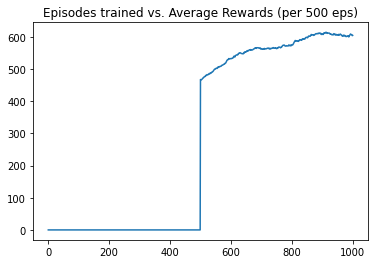

In [7]:
def run(training_mode, pretrained):
   
    env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
    env = make_env(env)  # Wraps the environment so that frames are grayscale 
    observation_space = env.observation_space.shape
    action_space = env.action_space.n
    agent = DQNAgent(state_space=observation_space,
                     action_space=action_space,
                     max_memory_size=30000,
                     batch_size=32,
                     gamma=0.90,
                     lr=0.00025,
                     dropout=0.,
                     exploration_max=1.0,
                     exploration_min=0.02,
                     exploration_decay=0.99,
                     double_dq=True,
                     pretrained=pretrained)
    
    num_episodes = 1000 # 10000
    env.reset()
    total_rewards = []
    
    for ep_num in tqdm(range(num_episodes)):
        state = env.reset()
        state = torch.Tensor([state])
        total_reward = 0
        steps = 0
        while True:
            if not training_mode:
                show_state(env, ep_num)
            action = agent.act(state)
            steps += 1
            
            state_next, reward, terminal, info = env.step(int(action[0]))
            total_reward += reward
            state_next = torch.Tensor([state_next])
            reward = torch.tensor([reward]).unsqueeze(0)
            
            terminal = torch.tensor([int(terminal)]).unsqueeze(0)
            
            if training_mode:
                agent.remember(state, action, reward, state_next, terminal)
                agent.experience_replay()
            
            state = state_next
            if terminal:
                break
        
        total_rewards.append(total_reward)

        print("Total reward after episode {} is {}".format(ep_num + 1, total_rewards[-1]))
        num_episodes += 1      
    
    if training_mode:
        with open("ending_position.pkl", "wb") as f:
            pickle.dump(agent.ending_position, f)
        with open("num_in_queue.pkl", "wb") as f:
            pickle.dump(agent.num_in_queue, f)
        with open("total_rewards.pkl", "wb") as f:
            pickle.dump(total_rewards, f)
        if agent.double_dq:
            torch.save(agent.local_net.state_dict(), "dq1.pt")
            torch.save(agent.target_net.state_dict(), "dq2.pt")
        else:
            torch.save(agent.dqn.state_dict(), "dq.pt")  
        torch.save(agent.STATE_MEM,  "STATE_MEM.pt")
        torch.save(agent.ACTION_MEM, "ACTION_MEM.pt")
        torch.save(agent.REWARD_MEM, "REWARD_MEM.pt")
        torch.save(agent.STATE2_MEM, "STATE2_MEM.pt")
        torch.save(agent.DONE_MEM,   "DONE_MEM.pt")
    
    env.close()
    
    if num_episodes > 500:
        plt.title("Episodes trained vs. Average Rewards (per 500 eps)")
        plt.plot([0 for _ in range(500)] + 
                 np.convolve(total_rewards, np.ones((500,))/500, mode="valid").tolist())
        plt.show()

run(training_mode=True, pretrained=False)